In [1]:
# DASK client set

import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

# get path for path changes in Jupyter notebook: File - Open from Path - insert relative_path
notebook_path = os.path.abspath(".")
_, _, relative_path = notebook_path.partition('/all/')
relative_path = '/all/' + relative_path
relative_path

'/all/Model/CESM2/Earth_System_Predictability/DIC'

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.interpolate import griddata
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_NWP_preprocessing import CESM2_NWP_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

In [4]:
# 1. DIC (Total)
cfg_var_DIC=CESM2_NWP_config()
cfg_var_DIC.year_s=1955
cfg_var_DIC.year_e=2020
cfg_var_DIC.setvar('DIC')

# 2. WVEL (Total)
cfg_var_WVEL=CESM2_NWP_config()
cfg_var_WVEL.year_s=1955
cfg_var_WVEL.year_e=2020
cfg_var_WVEL.setvar('WVEL')

if cfg_var_DIC.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

In [35]:
# 2. TEMP (Total)
cfg_var_TEMP=CESM2_NWP_config()
cfg_var_TEMP.year_s=1955
cfg_var_TEMP.year_e=2020
cfg_var_TEMP.setvar('TEMP')

In [58]:
# 2. FG_CO2 (Total)
cfg_var_FG_CO2=CESM2_NWP_config()
cfg_var_FG_CO2.year_s=1955
cfg_var_FG_CO2.year_e=2020
cfg_var_FG_CO2.setvar('FG_CO2')

In [64]:
# define preprocessing function

# exceptcv=['time','lon','lat','lev', 'TAREA', 'TLONG', 'TLAT', 'z_t', 'z_t_2', cfg_var_DIC.var, cfg_var_TEMP.var, cfg_var_WVEL.var, cfg_var_UVEL.var, cfg_var_VVEL.var]
# exceptcv=['time','lon','lat','lev', 'TAREA', 'TLONG', 'TLAT', 'z_t', 'z_t_2', 'z_w_top', 'ULONG', 'ULAT', cfg_var_DIC.var, cfg_var_WVEL.var]
exceptcv=['time','lon','lat','lev', 'TAREA', 'TLONG', 'TLAT', 'z_t', 'z_t_2', 'z_w_top', cfg_var_DIC.var, cfg_var_WVEL.var, cfg_var_TEMP.var, cfg_var_FG_CO2.var]

def process_coords_3d(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        # ds = ds.isel(z_t=slice(0, 39)) # ~39 layer (1000m)
        # ds = (ds.isel(z_t=slice(1, 39)) * ds.dz).sum(dim='z_t') / ds.dz.sum(dim='z_t')
        return ds
    else:
        return ds.set_coords(coord_vars)



def process_coords_3d_LE(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """
    Preprocessor function for CESM POP-style datasets.
    - Normalizes vertical coordinate: if z_t or z_t_2 exists, rename to 'depth'.
    - Replaces its values with z_t_new for consistency.
    - Optionally drops unnecessary coordinate variables for faster concatenation.
    """
    z_t_new = np.array([5.0000000e+00, 1.5000000e+01, 2.5000000e+01, 3.5000000e+01,
       4.5000000e+01, 5.5000000e+01, 6.5000000e+01, 7.5000000e+01,
       8.5000000e+01, 9.5000000e+01, 1.0500000e+02, 1.1500000e+02,
       1.2500000e+02, 1.3500000e+02, 1.4500000e+02, 1.5500000e+02,
       1.6509839e+02, 1.7547903e+02, 1.8629126e+02, 1.9766026e+02,
       2.0971138e+02, 2.2257828e+02, 2.3640883e+02, 2.5137015e+02,
       2.6765421e+02, 2.8548364e+02, 3.0511920e+02, 3.2686798e+02,
       3.5109348e+02, 3.7822760e+02, 4.0878464e+02, 4.4337769e+02,
       4.8273669e+02, 5.2772797e+02, 5.7937286e+02, 6.3886261e+02,
       7.0756329e+02, 7.8700250e+02, 8.7882520e+02, 9.8470581e+02,
       1.1062042e+03, 1.2445669e+03, 1.4004972e+03, 1.5739464e+03,
       1.7640033e+03, 1.9689442e+03, 2.1864565e+03, 2.4139714e+03,
       2.6490012e+03, 2.8893845e+03, 3.1334045e+03, 3.3797935e+03,
       3.6276702e+03, 3.8764519e+03, 4.1257681e+03, 4.3753926e+03,
       4.6251904e+03, 4.8750835e+03, 5.1250278e+03, 5.3750000e+03])
    
    # ------------------------------------------------------
    # 1️⃣ Normalize vertical coordinate name
    # ------------------------------------------------------
    if "z_t_2" in ds.dims:
        ds = ds.rename({"z_t_2": "depth"})
    elif "z_t" in ds.dims:
        ds = ds.rename({"z_t": "depth"})
    else:
        print("[Warning] No vertical coordinate (z_t or z_t_2) found — skipped.")
        return ds

    # Drop any leftover z_t/z_t_2 coordinate variable if it exists
    ds = ds.drop_vars(["z_t", "z_t_2"], errors="ignore")

    # ------------------------------------------------------
    # 2️⃣ Replace coordinate values with z_t_new
    # ------------------------------------------------------
    if "depth" in ds.coords:
        if len(ds["depth"]) == len(z_t_new):
            ds = ds.assign_coords(depth=z_t_new)
        else:
            print(f"[Warning] depth length mismatch: {len(ds['depth'])} vs {len(z_t_new)}")
    else:
        print("[Warning] depth coordinate missing after renaming.")

    # ------------------------------------------------------
    # 3️⃣ Clean up coordinate references inside variable attributes
    # ------------------------------------------------------
    for v in ds.data_vars:
        if "coordinates" in ds[v].attrs:
            ds[v].attrs["coordinates"] = (
                ds[v].attrs["coordinates"]
                .replace("z_t_2", "depth")
                .replace("z_t", "depth")
            )

    # ------------------------------------------------------
    # 4️⃣ Drop unnecessary coordinate variables and slice time
    # ------------------------------------------------------
    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars, errors="ignore")
        ds = ds.sel(time=slice(sd, ed))
    else:
        ds = ds.set_coords(coord_vars)

    return ds

start_date = cftime.DatetimeNoLeap(cfg_var_DIC.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_DIC.year_e+1, 1, 1)


# ds = ds.isel(lev=slice(1, 11))

In [7]:
# Read LE dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#DIC
cfg_var_DIC.LE_path_load(cfg_var_DIC.var)
cfg_var_DIC.LE_ds = xr.open_mfdataset(cfg_var_DIC.LE_file_list[0][11:12], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC.LE_ensembles][11:12], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d_LE(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_DIC.LE_ds = cfg_var_DIC.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_DIC.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC.LE_ds.time))
cfg_var_DIC.LE_ds = cfg_var_DIC.LE_ds.assign_coords(time=new_time)
cfg_var_DIC.LE_ds = cfg_var_DIC.LE_ds.rename({"depth": "z_t"})

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

# Read ADA dataset

# Quicker test for 2 ensembADAs only

start_time = time.time()

#DIC
cfg_var_DIC.ADA_path_load(cfg_var_DIC.var)
cfg_var_DIC.ADA_ds = xr.open_mfdataset(cfg_var_DIC.ADA_file_list[0][5:6], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC.ADA_ensembles][5:6], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_DIC.ADA_ds = cfg_var_DIC.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_DIC.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC.ADA_ds.time))
cfg_var_DIC.ADA_ds = cfg_var_DIC.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))

# Read WDA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#DIC
cfg_var_DIC.WDA_path_load(cfg_var_DIC.var)
cfg_var_DIC.WDA_ds = xr.open_mfdataset(cfg_var_DIC.WDA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC.WDA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_DIC.WDA_ds = cfg_var_DIC.WDA_ds.rename({"concat_dim": "ens_WDA"})
new_time = cfg_var_DIC.WDA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC.WDA_ds.time))
cfg_var_DIC.WDA_ds = cfg_var_DIC.WDA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading WDA: ' + str(elapsed_time))

# Read ODA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#DIC
cfg_var_DIC.ODA_path_load(cfg_var_DIC.var)
cfg_var_DIC.ODA_ds = xr.open_mfdataset(cfg_var_DIC.ODA_file_list[0][15:16], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC.ODA_ensembles][15:16], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC.ODA_ds = cfg_var_DIC.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_DIC.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC.ODA_ds.time))
cfg_var_DIC.ODA_ds = cfg_var_DIC.ODA_ds.assign_coords(time=new_time)


# cfg_var_DIC.ODA_path_load(cfg_var_DIC.var)
# cfg_var_DIC.ODA_file_list[0]

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))



start_time = time.time()

#regrids
import xcesm

lat_range = slice(10, 60)
lon_range = slice(110, 190)

cfg_var_DIC.LE_ds_rgd = (
    cfg_var_DIC.LE_ds['DIC']
    .isel(ens_LE=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_DIC.ODA_ds_rgd = (
    cfg_var_DIC.ODA_ds['DIC']
    .isel(ens_ODA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_DIC.ADA_ds_rgd = (
    cfg_var_DIC.ADA_ds['DIC']
    .isel(ens_ADA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_DIC.WDA_ds_rgd = (
    cfg_var_DIC.WDA_ds['DIC']
    .isel(ens_WDA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_DIC.LE_ds_rgd = cfg_var_DIC.LE_ds_rgd.sortby("time")
cfg_var_DIC.WDA_ds_rgd = cfg_var_DIC.WDA_ds_rgd.sortby("time")
cfg_var_DIC.ADA_ds_rgd = cfg_var_DIC.ADA_ds_rgd.sortby("time")
cfg_var_DIC.ODA_ds_rgd = cfg_var_DIC.ODA_ds_rgd.sortby("time")


cfg_var_DIC.LE_ds_rgd = cfg_var_DIC.LE_ds_rgd.assign_coords(z_t = cfg_var_DIC.ODA_ds_rgd.z_t)


end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding: ' + str(elapsed_time))

elasped time for reading LE: 16.91255807876587
elasped time for reading ADA: 1.8968214988708496
elasped time for reading WDA: 1.7747204303741455
elasped time for reading ODA: 2.833548069000244
elasped time for regriding: 264.7519271373749


In [9]:
cfg_var_WVEL.LE_ds

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 840, ens_LE: 1, nlat: 105, nlon: 73, z_w_top: 60, bnds: 2)
Coordinates:
    TLONG      (nlat, nlon) float64 61kB dask.array<chunksize=(105, 73), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 61kB dask.array<chunksize=(105, 73), meta=np.ndarray>
  * ens_LE     (ens_LE) int64 8B 11
  * z_w_top    (z_w_top) float32 240B 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * time       (time) object 7kB 1955-01-17 00:00:00 ... 2024-12-17 00:00:00
Dimensions without coordinates: nlat, nlon, bnds
Data variables:
    TAREA      (time, ens_LE, nlat, nlon) float64 52MB dask.array<chunksize=(60, 1, 105, 73), meta=np.ndarray>
    WVEL       (ens_LE, time, z_w_top, nlat, nlon) float32 2GB dask.array<chunksize=(1, 12, 1, 105, 73), meta=np.ndarray>
    time_bnds  (ens_LE, time, bnds) object 13kB dask.array<chunksize=(1, 732, 2), meta=np.ndarray>
Attributes: (12/13)
    CDI:               Climate Data Interface version 2.5.2 (https://mpimet.m...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    source:            CCSM POP2, the CCSM Ocean Component
    title:             b.e21.BHISTsmbb.f09_g17.LE2-1231.012
    history:           Wed Nov 26 11:08:07 2025: cdo -z zip_5 -O -w -selindex...
    time_period_freq:  month_1
    ...                ...
    contents:          Diagnostic and Prognostic Variables
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2020-11-12 at 11:25:05.9
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    CDO:               Climate Data Operators version 2.5.2 (https://mpimet.m...

In [31]:
# Read LE dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#WVEL
cfg_var_WVEL.LE_path_load(cfg_var_WVEL.var)
cfg_var_WVEL.LE_ds = xr.open_mfdataset(cfg_var_WVEL.LE_file_list[0][11:12], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_WVEL.LE_ensembles][11:12], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d_LE(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_WVEL.LE_ds = cfg_var_WVEL.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_WVEL.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_WVEL.LE_ds.time))
cfg_var_WVEL.LE_ds = cfg_var_WVEL.LE_ds.assign_coords(time=new_time)
# cfg_var_WVEL.LE_ds = cfg_var_WVEL.LE_ds.rename({"depth": "z_t"})

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

# Read ADA dataset

# Quicker test for 2 ensembADAs only

start_time = time.time()

#WVEL
cfg_var_WVEL.ADA_path_load(cfg_var_WVEL.var)
cfg_var_WVEL.ADA_ds = xr.open_mfdataset(cfg_var_WVEL.ADA_file_list[0][5:6], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_WVEL.ADA_ensembles][5:6], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_WVEL.ADA_ds = cfg_var_WVEL.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_WVEL.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_WVEL.ADA_ds.time))
cfg_var_WVEL.ADA_ds = cfg_var_WVEL.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))

# Read WDA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#WVEL
cfg_var_WVEL.WDA_path_load(cfg_var_WVEL.var)
cfg_var_WVEL.WDA_ds = xr.open_mfdataset(cfg_var_WVEL.WDA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_WVEL.WDA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_WVEL.WDA_ds = cfg_var_WVEL.WDA_ds.rename({"concat_dim": "ens_WDA"})
new_time = cfg_var_WVEL.WDA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_WVEL.WDA_ds.time))
cfg_var_WVEL.WDA_ds = cfg_var_WVEL.WDA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading WDA: ' + str(elapsed_time))

# Read ODA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#WVEL
cfg_var_WVEL.ODA_path_load(cfg_var_WVEL.var)
cfg_var_WVEL.ODA_ds = xr.open_mfdataset(cfg_var_WVEL.ODA_file_list[0][15:16], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_WVEL.ODA_ensembles][15:16], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_WVEL.ODA_ds = cfg_var_WVEL.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_WVEL.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_WVEL.ODA_ds.time))
cfg_var_WVEL.ODA_ds = cfg_var_WVEL.ODA_ds.assign_coords(time=new_time)


# cfg_var_WVEL.ODA_path_load(cfg_var_WVEL.var)
# cfg_var_WVEL.ODA_file_list[0]

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))



start_time = time.time()

#regrids
import xcesm

lat_range = slice(10, 60)
lon_range = slice(110, 190)

cfg_var_WVEL.LE_ds_rgd = (
    cfg_var_WVEL.LE_ds['WVEL']
    .isel(ens_LE=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_WVEL.ODA_ds_rgd = (
    cfg_var_WVEL.ODA_ds['WVEL']
    .isel(ens_ODA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_WVEL.ADA_ds_rgd = (
    cfg_var_WVEL.ADA_ds['WVEL']
    .isel(ens_ADA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_WVEL.WDA_ds_rgd = (
    cfg_var_WVEL.WDA_ds['WVEL']
    .isel(ens_WDA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_WVEL.LE_ds_rgd = cfg_var_WVEL.LE_ds_rgd.sortby("time")
cfg_var_WVEL.WDA_ds_rgd = cfg_var_WVEL.WDA_ds_rgd.sortby("time")
cfg_var_WVEL.ADA_ds_rgd = cfg_var_WVEL.ADA_ds_rgd.sortby("time")
cfg_var_WVEL.ODA_ds_rgd = cfg_var_WVEL.ODA_ds_rgd.sortby("time")


# cfg_var_WVEL.LE_ds_rgd = cfg_var_WVEL.LE_ds_rgd.assign_coords(z_t = cfg_var_WVEL.ODA_ds_rgd.z_t)


end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding: ' + str(elapsed_time))

elasped time for reading LE: 1.6098072528839111
elasped time for reading ADA: 1.8111395835876465
elasped time for reading WDA: 2.016486406326294
elasped time for reading ODA: 1.8620905876159668
elasped time for regriding: 224.45188903808594


In [37]:
# Read ADA dataset

# Quicker test for 2 ensembADAs only

start_time = time.time()

#TEMP
cfg_var_TEMP.ADA_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.ADA_ds = xr.open_mfdataset(cfg_var_TEMP.ADA_file_list[0][5:6], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.ADA_ensembles][5:6], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_TEMP.ADA_ds = cfg_var_TEMP.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_TEMP.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.ADA_ds.time))
cfg_var_TEMP.ADA_ds = cfg_var_TEMP.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))


# Read WDA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#TEMP
cfg_var_TEMP.WDA_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.WDA_ds = xr.open_mfdataset(cfg_var_TEMP.WDA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.WDA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_TEMP.WDA_ds = cfg_var_TEMP.WDA_ds.rename({"concat_dim": "ens_WDA"})
new_time = cfg_var_TEMP.WDA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.WDA_ds.time))
cfg_var_TEMP.WDA_ds = cfg_var_TEMP.WDA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading WDA: ' + str(elapsed_time))


# Read ODA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#TEMP
cfg_var_TEMP.ODA_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.ODA_ds = xr.open_mfdataset(cfg_var_TEMP.ODA_file_list[0][15:16], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.ODA_ensembles][15:16], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP.ODA_ds = cfg_var_TEMP.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_TEMP.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.ODA_ds.time))
cfg_var_TEMP.ODA_ds = cfg_var_TEMP.ODA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))



#LE TEMP
start_time = time.time()
cfg_var_TEMP.LE_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.LE_ds = xr.open_mfdataset(cfg_var_TEMP.LE_file_list[0][11:12], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.LE_ensembles][11:12], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d_LE(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TEMP.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.LE_ds.time))
cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.assign_coords(time=new_time)
cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.rename({"depth": "z_t"})
cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.assign_coords(z_t = cfg_var_TEMP.ODA_ds.z_t)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

# cfg_var_TEMP.ODA_path_load(cfg_var_TEMP.var)
# cfg_var_TEMP.ODA_file_list[0]

#regrids
import xcesm

# cfg_var_TEMP.ODA_ds_rgd = cfg_var_TEMP.ODA_ds['TEMP'].isel(ens_ODA=5).utils.regrid()
# cfg_var_TEMP.ADA_ds_rgd = cfg_var_TEMP.ADA_ds['TEMP'].isel(ens_ADA=5).utils.regrid()
# cfg_var_TEMP.WDA_ds_rgd = cfg_var_TEMP.WDA_ds['TEMP'].isel(ens_WDA=0).utils.regrid()

lat_range = slice(10, 60)
lon_range = slice(110, 190)

start_time = time.time()

cfg_var_TEMP.ODA_ds_rgd = (
    cfg_var_TEMP.ODA_ds['TEMP']
    .isel(ens_ODA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)
end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding ODA: ' + str(elapsed_time))

cfg_var_TEMP.ADA_ds_rgd = (
    cfg_var_TEMP.ADA_ds['TEMP']
    .isel(ens_ADA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding ADA: ' + str(elapsed_time))

cfg_var_TEMP.WDA_ds_rgd = (
    cfg_var_TEMP.WDA_ds['TEMP']
    .isel(ens_WDA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding WDA: ' + str(elapsed_time))

cfg_var_TEMP.LE_ds_rgd = (
    cfg_var_TEMP.LE_ds['TEMP']
    .isel(ens_LE=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding LE: ' + str(elapsed_time))

cfg_var_TEMP.WDA_ds_rgd = cfg_var_TEMP.WDA_ds_rgd.sortby("time")
cfg_var_TEMP.ADA_ds_rgd = cfg_var_TEMP.ADA_ds_rgd.sortby("time")
cfg_var_TEMP.ODA_ds_rgd = cfg_var_TEMP.ODA_ds_rgd.sortby("time")
cfg_var_TEMP.LE_ds_rgd = cfg_var_TEMP.LE_ds_rgd.sortby("time")

elasped time for reading ADA: 2.0984947681427
elasped time for reading WDA: 1.7739830017089844
elasped time for reading ODA: 3.9873862266540527
elasped time for reading LE: 1.8015587329864502
elasped time for regriding ODA: 44.76050043106079
elasped time for regriding ADA: 87.28262710571289
elasped time for regriding WDA: 132.10222816467285
elasped time for regriding LE: 181.66410398483276


In [68]:
# Read LE dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#FG_CO2
cfg_var_FG_CO2.LE_path_load(cfg_var_FG_CO2.var)
cfg_var_FG_CO2.LE_ds = xr.open_mfdataset(cfg_var_FG_CO2.LE_file_list[0][11:12], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_FG_CO2.LE_ensembles][11:12], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d_LE(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_FG_CO2.LE_ds = cfg_var_FG_CO2.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_FG_CO2.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_FG_CO2.LE_ds.time))
cfg_var_FG_CO2.LE_ds = cfg_var_FG_CO2.LE_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

# Read ADA dataset

# Quicker test for 2 ensembADAs only

start_time = time.time()

#FG_CO2
cfg_var_FG_CO2.ADA_path_load(cfg_var_FG_CO2.var)
cfg_var_FG_CO2.ADA_ds = xr.open_mfdataset(cfg_var_FG_CO2.ADA_file_list[0][5:6], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_FG_CO2.ADA_ensembles][5:6], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_FG_CO2.ADA_ds = cfg_var_FG_CO2.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_FG_CO2.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_FG_CO2.ADA_ds.time))
cfg_var_FG_CO2.ADA_ds = cfg_var_FG_CO2.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))

# Read WDA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#FG_CO2
cfg_var_FG_CO2.WDA_path_load(cfg_var_FG_CO2.var)
cfg_var_FG_CO2.WDA_ds = xr.open_mfdataset(cfg_var_FG_CO2.WDA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_FG_CO2.WDA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_FG_CO2.WDA_ds = cfg_var_FG_CO2.WDA_ds.rename({"concat_dim": "ens_WDA"})
new_time = cfg_var_FG_CO2.WDA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_FG_CO2.WDA_ds.time))
cfg_var_FG_CO2.WDA_ds = cfg_var_FG_CO2.WDA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading WDA: ' + str(elapsed_time))

# Read ODA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#FG_CO2
cfg_var_FG_CO2.ODA_path_load(cfg_var_FG_CO2.var)
cfg_var_FG_CO2.ODA_ds = xr.open_mfdataset(cfg_var_FG_CO2.ODA_file_list[0][15:16], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_FG_CO2.ODA_ensembles][15:16], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_FG_CO2.ODA_ds = cfg_var_FG_CO2.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_FG_CO2.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_FG_CO2.ODA_ds.time))
cfg_var_FG_CO2.ODA_ds = cfg_var_FG_CO2.ODA_ds.assign_coords(time=new_time)


# cfg_var_FG_CO2.ODA_path_load(cfg_var_FG_CO2.var)
# cfg_var_FG_CO2.ODA_file_list[0]

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))



start_time = time.time()

#regrids
import xcesm

lat_range = slice(10, 60)
lon_range = slice(110, 190)

cfg_var_FG_CO2.LE_ds_rgd = (
    cfg_var_FG_CO2.LE_ds['FG_CO2']
    .isel(ens_LE=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_FG_CO2.ODA_ds_rgd = (
    cfg_var_FG_CO2.ODA_ds['FG_CO2']
    .isel(ens_ODA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_FG_CO2.ADA_ds_rgd = (
    cfg_var_FG_CO2.ADA_ds['FG_CO2']
    .isel(ens_ADA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_FG_CO2.WDA_ds_rgd = (
    cfg_var_FG_CO2.WDA_ds['FG_CO2']
    .isel(ens_WDA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

cfg_var_FG_CO2.LE_ds_rgd = cfg_var_FG_CO2.LE_ds_rgd.sortby("time")
cfg_var_FG_CO2.WDA_ds_rgd = cfg_var_FG_CO2.WDA_ds_rgd.sortby("time")
cfg_var_FG_CO2.ADA_ds_rgd = cfg_var_FG_CO2.ADA_ds_rgd.sortby("time")
cfg_var_FG_CO2.ODA_ds_rgd = cfg_var_FG_CO2.ODA_ds_rgd.sortby("time")


# cfg_var_FG_CO2.LE_ds_rgd = cfg_var_FG_CO2.LE_ds_rgd.assign_coords(z_t = cfg_var_FG_CO2.ODA_ds_rgd.z_t)


end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding: ' + str(elapsed_time))

elasped time for reading LE: 1.5429017543792725
elasped time for reading ADA: 1.7964251041412354
elasped time for reading WDA: 1.6559906005859375
elasped time for reading ODA: 2.925403356552124


AttributeError: 'DataArray' object has no attribute 'z_t'

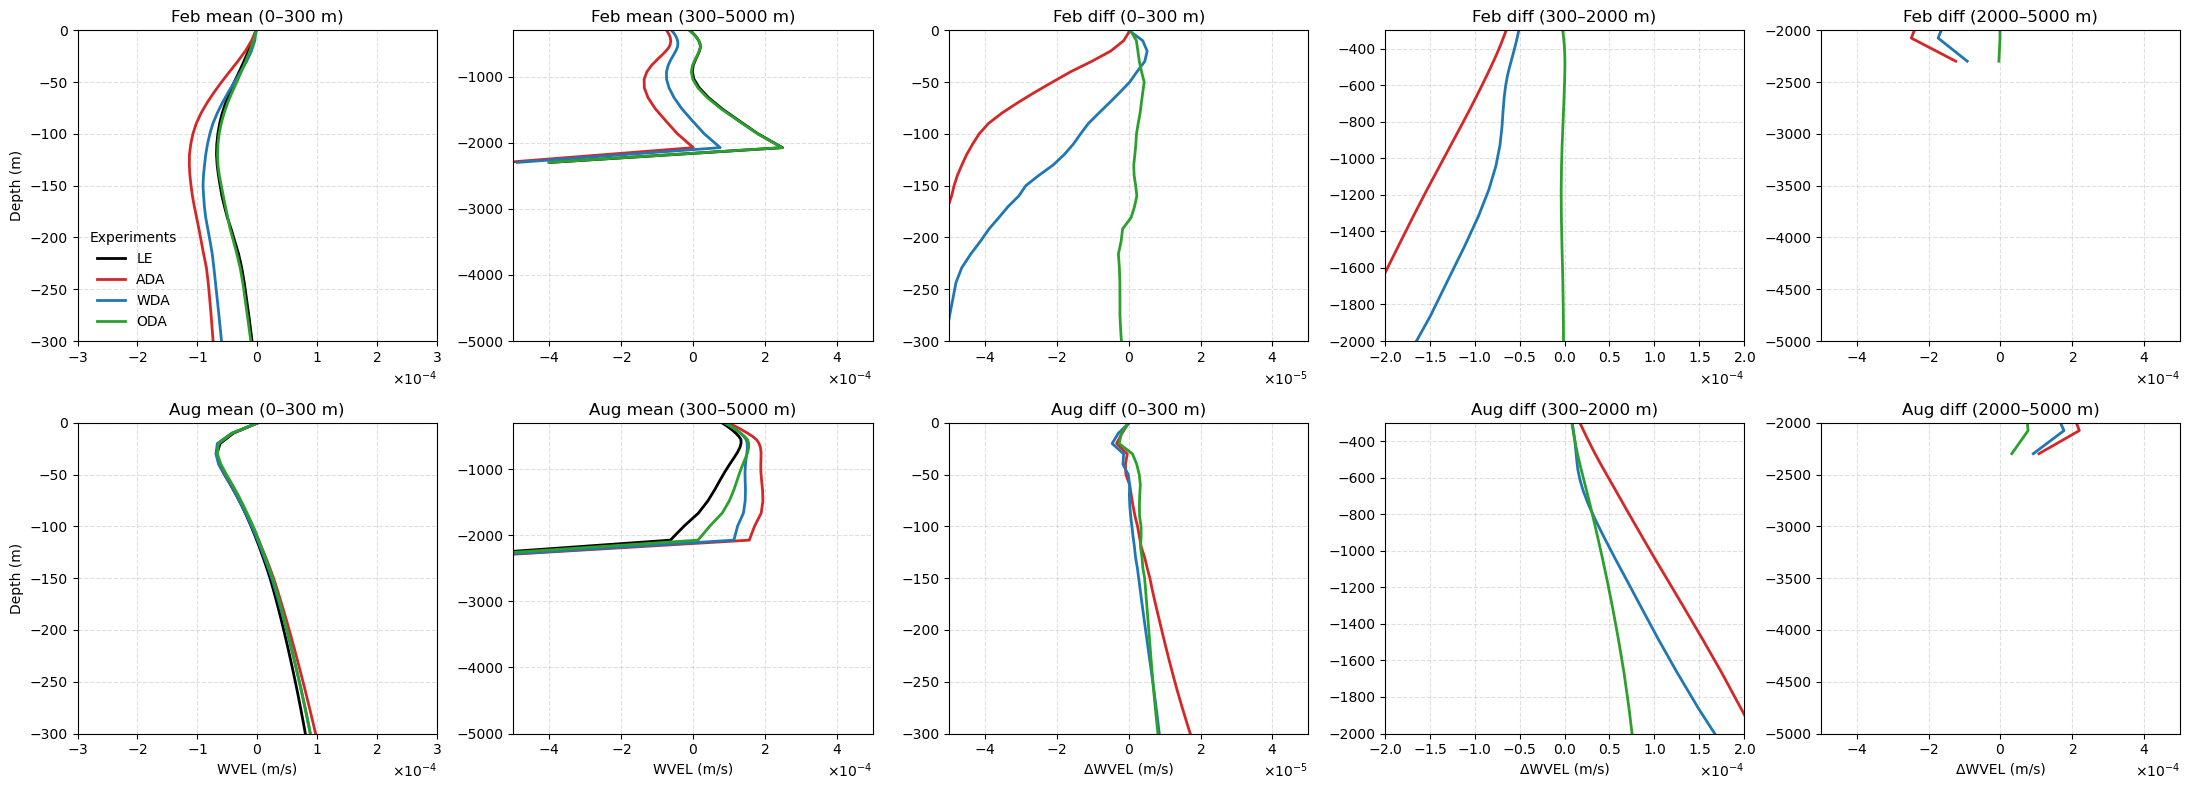

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ==========================================================
# 1) Helper: extract monthly-mean vertical structure (z_w_top 사용)
# ==========================================================
def extract_wvel_vertical_monthlymean(ds_wvel, lat_pt=31, lon_pt=140, depth_range=(0, -5000)):
    """
    Extract monthly mean vertical velocity profile using z_w_top (m, negative downward)
    """
    ds_wvel = ds_wvel.assign_coords(z_w_top=-ds_wvel.z_w_top / 100.0)  # cm→m, flip sign (to positive upward)
    da = ds_wvel.sel(lat=lat_pt, lon=lon_pt, method="nearest").sel(z_w_top=slice(*depth_range))
    return da.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_wvel_vertical_monthlymean(cfg_var_WVEL.LE_ds_rgd)
vert_ADA = extract_wvel_vertical_monthlymean(cfg_var_WVEL.ADA_ds_rgd)
vert_WDA = extract_wvel_vertical_monthlymean(cfg_var_WVEL.WDA_ds_rgd)
vert_ODA = extract_wvel_vertical_monthlymean(cfg_var_WVEL.ODA_ds_rgd)

Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 4) Plot: 2×5 panels (same layout)
# ==========================================================
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(22, 8), sharey=False)

colors_main = ["k", "C3", "C0", "C2"]
colors_diff = ["C3", "C0", "C2"]

# ---------- (1행) February ----------
titles_Feb = [
    "Feb mean (0–300 m)",
    "Feb mean (300–5000 m)",
    "Feb diff (0–300 m)",
    "Feb diff (300–2000 m)",
    "Feb diff (2000–5000 m)"
]
for j in range(5):
    axes[0, j].set_title(titles_Feb[j])

# Mean panels (0–300 m, 300–5000 m)
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_w_top"], color=color, lw=2, label=label)
    axes[0,1].plot(Feb_profiles[label], Feb_profiles[label]["z_w_top"], color=color, lw=2)

# Diff panels
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    for ax, (zmin, zmax) in zip(axes[0,2:], [(0, -300), (-300, -2000), (-2000, -5000)]):
        ax.plot(diff_Feb[label], diff_Feb[label]["z_w_top"], color=color, lw=2)

# ---------- (2행) August ----------
titles_Aug = [
    "Aug mean (0–300 m)",
    "Aug mean (300–5000 m)",
    "Aug diff (0–300 m)",
    "Aug diff (300–2000 m)",
    "Aug diff (2000–5000 m)"
]
for j in range(5):
    axes[1, j].set_title(titles_Aug[j])

# Mean panels
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,0].plot(Aug_profiles[label], Aug_profiles[label]["z_w_top"], color=color, lw=2, label=label)
    axes[1,1].plot(Aug_profiles[label], Aug_profiles[label]["z_w_top"], color=color, lw=2)

# Diff panels
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    for ax, (zmin, zmax) in zip(axes[1,2:], [(0, -300), (-300, -2000), (-2000, -5000)]):
        ax.plot(diff_Aug[label], diff_Aug[label]["z_w_top"], color=color, lw=2)

# ---------- 공통 축 설정 ----------
for i in range(2):
    for j in range(5):
        axes[i, j].grid(True, ls="--", alpha=0.4)

# Depth 범위
axes[0,0].set_ylim(-300, 0)
axes[1,0].set_ylim(-300, 0)
axes[0,1].set_ylim(-5000, -300)
axes[1,1].set_ylim(-5000, -300)
axes[0,2].set_ylim(-300, 0)
axes[1,2].set_ylim(-300, 0)
axes[0,3].set_ylim(-2000, -300)
axes[1,3].set_ylim(-2000, -300)
axes[0,4].set_ylim(-5000, -2000)
axes[1,4].set_ylim(-5000, -2000)

# X범위 (WVEL typical scale)
axes[0,0].set_xlim(-0.0003, 0.0003)
axes[1,0].set_xlim(-0.0003, 0.0003)
axes[0,1].set_xlim(-0.0005, 0.0005)
axes[1,1].set_xlim(-0.0005, 0.0005)
axes[0,2].set_xlim(-0.00005, 0.00005)
axes[1,2].set_xlim(-0.00005, 0.00005)
axes[0,3].set_xlim(-0.0002, 0.0002)
axes[1,3].set_xlim(-0.0002, 0.0002)
axes[0,4].set_xlim(-0.0005, 0.0005)
axes[1,4].set_xlim(-0.0005, 0.0005)

# ---------- 지수 표기 ----------
for i in range(2):
    for j in range(5):
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-3, 3))
        axes[i, j].xaxis.set_major_formatter(formatter)
        axes[i, j].ticklabel_format(axis='x', style='sci', scilimits=(-3, 3))

# ---------- Labels ----------
axes[1,0].set_xlabel("WVEL (m/s)")
axes[1,1].set_xlabel("WVEL (m/s)")
for j in [2, 3, 4]:
    axes[1,j].set_xlabel("ΔWVEL (m/s)")
axes[0,0].set_ylabel("Depth (m)")
axes[1,0].set_ylabel("Depth (m)")

axes[0,0].legend(loc="lower left", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ==========================================================
# 1) Helper: extract monthly-mean vertical structure (z_w_top 사용)
# ==========================================================
def extract_wvel_vertical_monthlymean(ds_wvel, lat_pt=31, lon_range=(140, 165), depth_range=(0, -5000)):
    """
    Extract monthly mean vertical velocity profile using z_w_top (m, negative downward)
    - latitude fixed (nearest to lat_pt)
    - longitude averaged over lon_range
    - NaN-safe mean: if any NaN exists along lon, the mean becomes NaN
    """
    ds_wvel = ds_wvel.assign_coords(z_w_top=-ds_wvel.z_w_top / 100.0)  # cm→m, flip sign (upward positive)
    da = ds_wvel.sel(lat=lat_pt, method="nearest").sel(lon=slice(*lon_range)).sel(z_w_top=slice(*depth_range))
    
    # NaN-safe lon mean
    valid_mask = da.notnull().all(dim="lon")
    mean_val = da.mean(dim="lon", skipna=False)
    mean_val = mean_val.where(valid_mask)
    
    return mean_val.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_wvel_vertical_monthlymean(cfg_var_WVEL.LE_ds_rgd)
vert_ADA = extract_wvel_vertical_monthlymean(cfg_var_WVEL.ADA_ds_rgd)
vert_WDA = extract_wvel_vertical_monthlymean(cfg_var_WVEL.WDA_ds_rgd)
vert_ODA = extract_wvel_vertical_monthlymean(cfg_var_WVEL.ODA_ds_rgd)

Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 4) Plot: 2×4 panels
# ==========================================================
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8), sharey=False)
colors_main = ["k", "C3", "C0", "C2"]
colors_diff = ["C3", "C0", "C2"]

# ---------- (1행) February ----------
titles_Feb = [
    "Feb mean (0–300 m)",
    "Feb mean (300–2000 m)",
    "Feb diff (0–300 m)",
    "Feb diff (300–2000 m)"
]
for j in range(4):
    axes[0, j].set_title(titles_Feb[j])

# Mean panels
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_w_top"], color=color, lw=2, label=label)
    axes[0,1].plot(Feb_profiles[label], Feb_profiles[label]["z_w_top"], color=color, lw=2)

# Diff panels
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[0,2].plot(diff_Feb[label], diff_Feb[label]["z_w_top"], color=color, lw=2)
    axes[0,3].plot(diff_Feb[label], diff_Feb[label]["z_w_top"], color=color, lw=2)

# ---------- (2행) August ----------
titles_Aug = [
    "Aug mean (0–300 m)",
    "Aug mean (300–2000 m)",
    "Aug diff (0–300 m)",
    "Aug diff (300–2000 m)"
]
for j in range(4):
    axes[1, j].set_title(titles_Aug[j])

for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,0].plot(Aug_profiles[label], Aug_profiles[label]["z_w_top"], color=color, lw=2, label=label)
    axes[1,1].plot(Aug_profiles[label], Aug_profiles[label]["z_w_top"], color=color, lw=2)

for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[1,2].plot(diff_Aug[label], diff_Aug[label]["z_w_top"], color=color, lw=2)
    axes[1,3].plot(diff_Aug[label], diff_Aug[label]["z_w_top"], color=color, lw=2)

# ---------- 공통 축 설정 ----------
for i in range(2):
    for j in range(4):
        axes[i, j].grid(True, ls="--", alpha=0.4)

# Depth 범위
axes[0,0].set_ylim(-300, 0)
axes[1,0].set_ylim(-300, 0)
axes[0,1].set_ylim(-2000, -300)
axes[1,1].set_ylim(-2000, -300)
axes[0,2].set_ylim(-300, 0)
axes[1,2].set_ylim(-300, 0)
axes[0,3].set_ylim(-2000, -300)
axes[1,3].set_ylim(-2000, -300)

# X범위 (WVEL typical scale)
axes[0,0].set_xlim(-0.0003, 0.0003)
axes[1,0].set_xlim(-0.0003, 0.0003)
axes[0,1].set_xlim(-0.0002, 0.0002)
axes[1,1].set_xlim(-0.0001, 0.0001)
axes[0,2].set_xlim(-0.00005, 0.00005)
axes[1,2].set_xlim(-0.00005, 0.00005)
axes[0,3].set_xlim(-0.0005, 0.0005)
axes[1,3].set_xlim(-0.0005, 0.0005)

# ---------- 지수 표기 ----------
for i in range(2):
    for j in range(4):
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-3, 3))
        axes[i, j].xaxis.set_major_formatter(formatter)
        axes[i, j].ticklabel_format(axis='x', style='sci', scilimits=(-3, 3))

# ---------- Labels ----------
axes[1,0].set_xlabel("WVEL (m/s)")
axes[1,1].set_xlabel("WVEL (m/s)")
for j in [2, 3]:
    axes[1,j].set_xlabel("ΔWVEL (m/s)")
axes[0,0].set_ylabel("Depth (m)")
axes[1,0].set_ylabel("Depth (m)")

axes[0,0].legend(loc="lower left", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


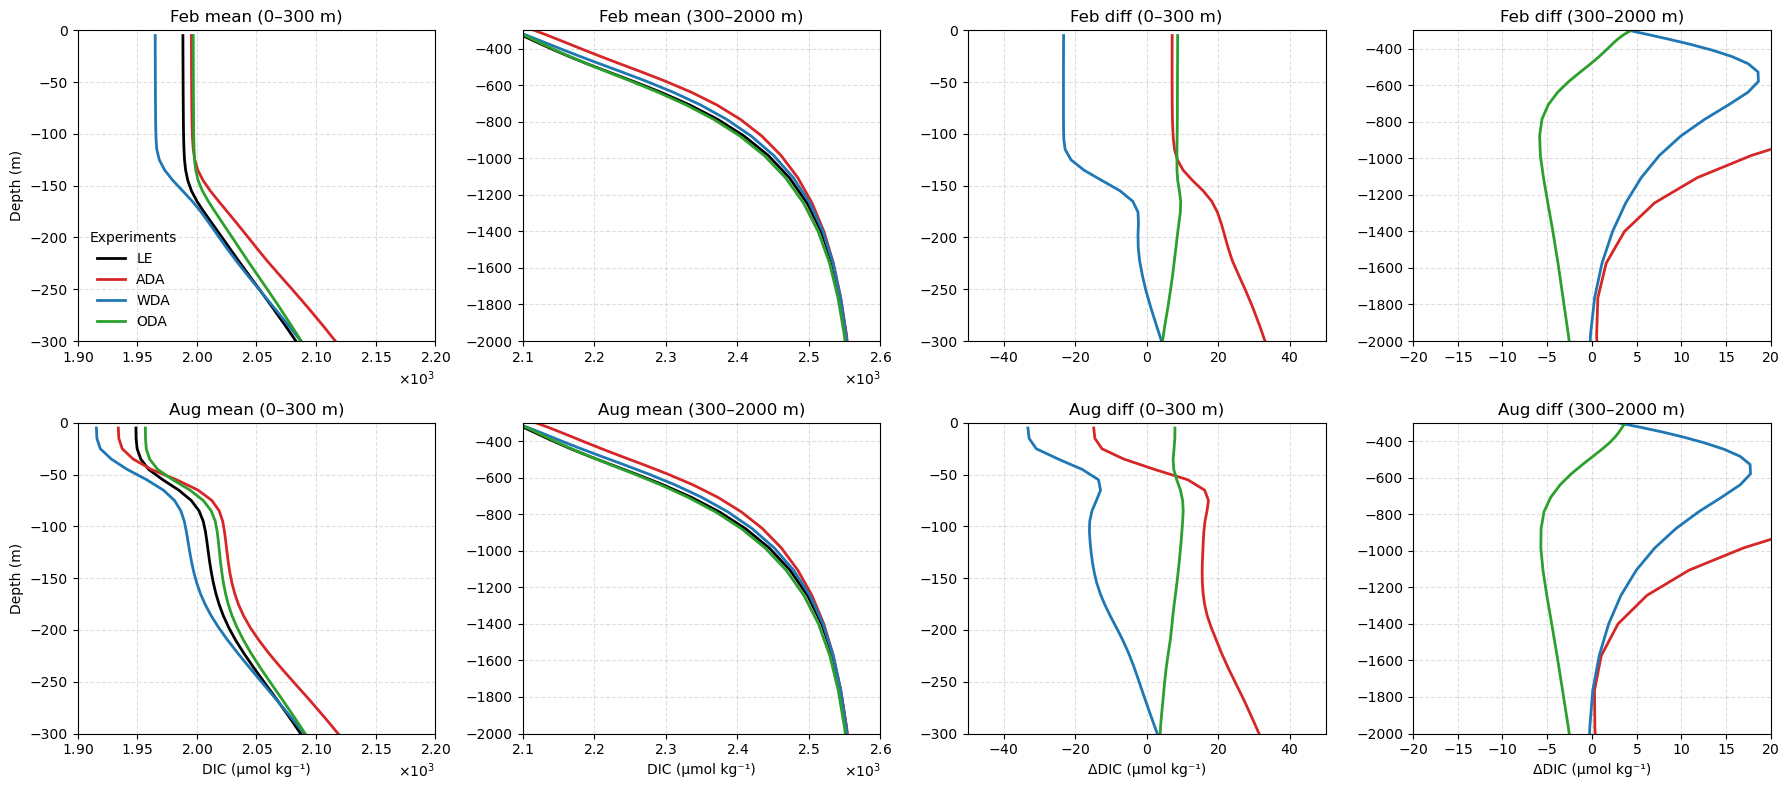

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ==========================================================
# 1) Helper: extract monthly-mean vertical structure (z_t 사용)
# ==========================================================
def extract_dic_vertical_monthlymean(ds_dic, lat_pt=31, lon_range=(140, 165), depth_range=(0, -5000)):
    """
    Extract monthly mean DIC profile using z_t (m, negative downward)
    - latitude fixed (nearest to lat_pt)
    - longitude averaged over lon_range
    - NaN-safe mean: if any NaN exists along lon, the mean becomes NaN
    """
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)  # cm→m, flip sign (upward positive)
    da = ds_dic.sel(lat=lat_pt, method="nearest").sel(lon=slice(*lon_range)).sel(z_t=slice(*depth_range))
    
    # NaN-safe lon mean
    valid_mask = da.notnull().all(dim="lon")
    mean_val = da.mean(dim="lon", skipna=False)
    mean_val = mean_val.where(valid_mask)
    
    return mean_val.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_dic_vertical_monthlymean(cfg_var_DIC.LE_ds_rgd)
vert_ADA = extract_dic_vertical_monthlymean(cfg_var_DIC.ADA_ds_rgd)
vert_WDA = extract_dic_vertical_monthlymean(cfg_var_DIC.WDA_ds_rgd)
vert_ODA = extract_dic_vertical_monthlymean(cfg_var_DIC.ODA_ds_rgd)

Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 4) Plot: 2×4 panels (0–300 m, 300–2000 m only)
# ==========================================================
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8), sharey=False)
colors_main = ["k", "C3", "C0", "C2"]
colors_diff = ["C3", "C0", "C2"]

# ---------- (1행) February ----------
titles_Feb = [
    "Feb mean (0–300 m)",
    "Feb mean (300–2000 m)",
    "Feb diff (0–300 m)",
    "Feb diff (300–2000 m)"
]
for j in range(4):
    axes[0, j].set_title(titles_Feb[j])

# Mean panels
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[0,1].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2)

# Diff panels
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[0,2].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)
    axes[0,3].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)

# ---------- (2행) August ----------
titles_Aug = [
    "Aug mean (0–300 m)",
    "Aug mean (300–2000 m)",
    "Aug diff (0–300 m)",
    "Aug diff (300–2000 m)"
]
for j in range(4):
    axes[1, j].set_title(titles_Aug[j])

for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,0].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[1,1].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2)

for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[1,2].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)
    axes[1,3].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)

# ---------- 공통 축 설정 ----------
for i in range(2):
    for j in range(4):
        axes[i, j].grid(True, ls="--", alpha=0.4)

# Depth 범위
axes[0,0].set_ylim(-300, 0)
axes[1,0].set_ylim(-300, 0)
axes[0,1].set_ylim(-2000, -300)
axes[1,1].set_ylim(-2000, -300)
axes[0,2].set_ylim(-300, 0)
axes[1,2].set_ylim(-300, 0)
axes[0,3].set_ylim(-2000, -300)
axes[1,3].set_ylim(-2000, -300)

# X범위 (DIC typical scale)
axes[0,0].set_xlim(1900, 2200)
axes[1,0].set_xlim(1900, 2200)
axes[0,1].set_xlim(2100, 2600)
axes[1,1].set_xlim(2100, 2600)
axes[0,2].set_xlim(-50, 50)
axes[1,2].set_xlim(-50, 50)
axes[0,3].set_xlim(-20, 20)
axes[1,3].set_xlim(-20, 20)

# ---------- 지수 표기 ----------
for i in range(2):
    for j in range(4):
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 3))
        axes[i, j].xaxis.set_major_formatter(formatter)
        axes[i, j].ticklabel_format(axis='x', style='sci', scilimits=(-2, 3))

# ---------- Labels ----------
axes[1,0].set_xlabel("DIC (µmol kg⁻¹)")
axes[1,1].set_xlabel("DIC (µmol kg⁻¹)")
for j in [2, 3]:
    axes[1,j].set_xlabel("ΔDIC (µmol kg⁻¹)")
axes[0,0].set_ylabel("Depth (m)")
axes[1,0].set_ylabel("Depth (m)")

axes[0,0].legend(loc="lower left", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


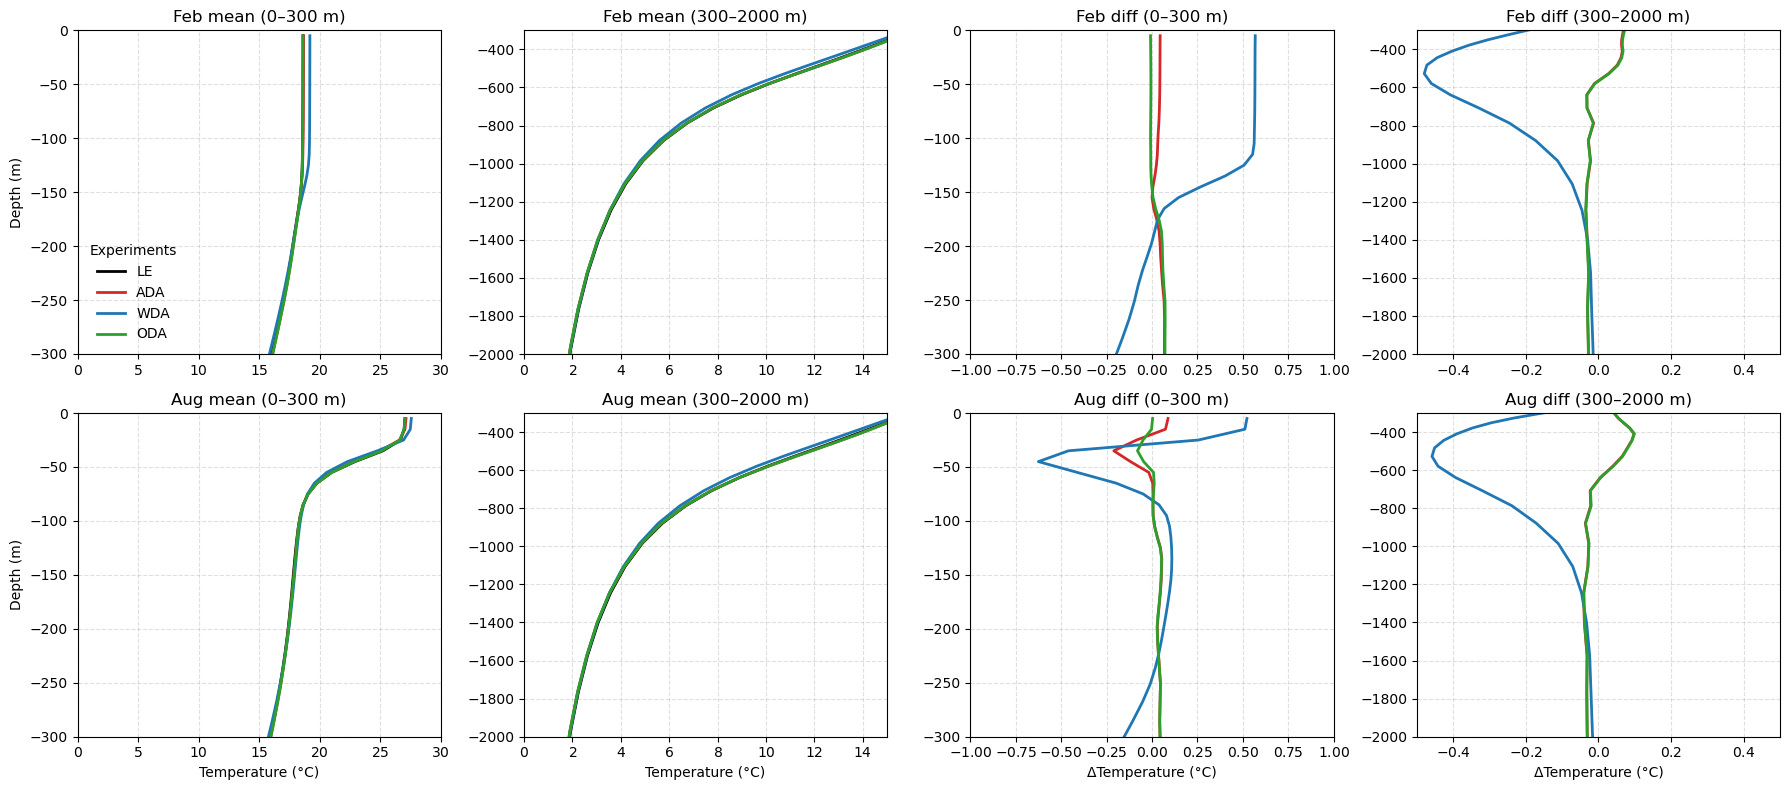

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ==========================================================
# 1) Helper: extract monthly-mean vertical structure (z_t 사용)
# ==========================================================
def extract_temp_vertical_monthlymean(ds_temp, lat_pt=31, lon_range=(140, 165), depth_range=(0, -5000)):
    """
    Extract monthly mean temperature profile using z_t (m, negative downward)
    - latitude fixed (nearest to lat_pt)
    - longitude averaged over lon_range
    - NaN-safe mean: if any NaN exists along lon, the mean becomes NaN
    """
    ds_temp = ds_temp.assign_coords(z_t=-ds_temp.z_t / 100.0)  # cm→m, flip sign (upward positive)
    da = ds_temp.sel(lat=lat_pt, method="nearest").sel(lon=slice(*lon_range)).sel(z_t=slice(*depth_range))
    
    # NaN-safe lon mean
    valid_mask = da.notnull().all(dim="lon")
    mean_val = da.mean(dim="lon", skipna=False)
    mean_val = mean_val.where(valid_mask)
    
    return mean_val.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_temp_vertical_monthlymean(cfg_var_TEMP.LE_ds_rgd)
vert_ADA = extract_temp_vertical_monthlymean(cfg_var_TEMP.ADA_ds_rgd)
vert_WDA = extract_temp_vertical_monthlymean(cfg_var_TEMP.WDA_ds_rgd)
vert_ODA = extract_temp_vertical_monthlymean(cfg_var_TEMP.ODA_ds_rgd)

Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 4) Plot: 2×4 panels (0–300 m, 300–2000 m only)
# ==========================================================
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8), sharey=False)
colors_main = ["k", "C3", "C0", "C2"]
colors_diff = ["C3", "C0", "C2"]

# ---------- (1행) February ----------
titles_Feb = [
    "Feb mean (0–300 m)",
    "Feb mean (300–2000 m)",
    "Feb diff (0–300 m)",
    "Feb diff (300–2000 m)"
]
for j in range(4):
    axes[0, j].set_title(titles_Feb[j])

# Mean panels
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[0,1].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2)

# Diff panels
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[0,2].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)
    axes[0,3].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)

# ---------- (2행) August ----------
titles_Aug = [
    "Aug mean (0–300 m)",
    "Aug mean (300–2000 m)",
    "Aug diff (0–300 m)",
    "Aug diff (300–2000 m)"
]
for j in range(4):
    axes[1, j].set_title(titles_Aug[j])

for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,0].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[1,1].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2)

for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[1,2].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)
    axes[1,3].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)

# ---------- 공통 축 설정 ----------
for i in range(2):
    for j in range(4):
        axes[i, j].grid(True, ls="--", alpha=0.4)

# Depth 범위
axes[0,0].set_ylim(-300, 0)
axes[1,0].set_ylim(-300, 0)
axes[0,1].set_ylim(-2000, -300)
axes[1,1].set_ylim(-2000, -300)
axes[0,2].set_ylim(-300, 0)
axes[1,2].set_ylim(-300, 0)
axes[0,3].set_ylim(-2000, -300)
axes[1,3].set_ylim(-2000, -300)

# X범위 (TEMP typical scale)
axes[0,0].set_xlim(0, 30)
axes[1,0].set_xlim(0, 30)
axes[0,1].set_xlim(0, 15)
axes[1,1].set_xlim(0, 15)
axes[0,2].set_xlim(-1, 1)
axes[1,2].set_xlim(-1, 1)
axes[0,3].set_xlim(-0.5, 0.5)
axes[1,3].set_xlim(-0.5, 0.5)

# ---------- 지수 표기 ----------
for i in range(2):
    for j in range(4):
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 3))
        axes[i, j].xaxis.set_major_formatter(formatter)
        axes[i, j].ticklabel_format(axis='x', style='sci', scilimits=(-2, 3))

# ---------- Labels ----------
axes[1,0].set_xlabel("Temperature (°C)")
axes[1,1].set_xlabel("Temperature (°C)")
for j in [2, 3]:
    axes[1,j].set_xlabel("ΔTemperature (°C)")
axes[0,0].set_ylabel("Depth (m)")
axes[1,0].set_ylabel("Depth (m)")

axes[0,0].legend(loc="lower left", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ==========================================================
# 1) Helper: extract monthly-mean vertical gradient (dT/dz)
# ==========================================================
def extract_temp_vertical_gradient_monthlymean(ds_temp, lat_pt=31, lon_range=(140, 165), depth_range=(0, -5000)):
    """
    Compute monthly mean vertical temperature gradient (dT/dz, °C/m)
    using z_t (m, negative downward)
    """
    ds_temp = ds_temp.assign_coords(z_t=-ds_temp.z_t / 100.0)  # cm→m, flip sign (upward positive)
    da = ds_temp.sel(lat=lat_pt, method="nearest").sel(lon=slice(*lon_range)).sel(z_t=slice(*depth_range))

    # NaN-safe lon mean
    valid_mask = da.notnull().all(dim="lon")
    mean_val = da.mean(dim="lon", skipna=False)
    mean_val = mean_val.where(valid_mask)

    # --- vertical gradient dT/dz (°C/m)
    dz = np.gradient(mean_val["z_t"])
    dTdz = np.gradient(mean_val, mean_val["z_t"], axis=mean_val.get_axis_num("z_t"))

    da_grad = mean_val.copy(data=dTdz)
    da_grad.attrs["units"] = "°C/m"
    return da_grad.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_temp_vertical_gradient_monthlymean(cfg_var_TEMP.LE_ds_rgd)
vert_ADA = extract_temp_vertical_gradient_monthlymean(cfg_var_TEMP.ADA_ds_rgd)
vert_WDA = extract_temp_vertical_gradient_monthlymean(cfg_var_TEMP.WDA_ds_rgd)
vert_ODA = extract_temp_vertical_gradient_monthlymean(cfg_var_TEMP.ODA_ds_rgd)

Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 4) Plot: 2×4 panels (0–300 m, 300–2000 m only)
# ==========================================================
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8), sharey=False)
colors_main = ["k", "C3", "C0", "C2"]
colors_diff = ["C3", "C0", "C2"]

titles_Feb = [
    "Feb dT/dz (0–300 m)",
    "Feb dT/dz (300–2000 m)",
    "Feb Δ(dT/dz) (0–300 m)",
    "Feb Δ(dT/dz) (300–2000 m)"
]
for j in range(4):
    axes[0, j].set_title(titles_Feb[j])

# ---------- (1행) February ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[0,1].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2)
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[0,2].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)
    axes[0,3].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)

# ---------- (2행) August ----------
titles_Aug = [
    "Aug dT/dz (0–300 m)",
    "Aug dT/dz (300–2000 m)",
    "Aug Δ(dT/dz) (0–300 m)",
    "Aug Δ(dT/dz) (300–2000 m)"
]
for j in range(4):
    axes[1, j].set_title(titles_Aug[j])

for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,0].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[1,1].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2)
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[1,2].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)
    axes[1,3].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)

# ---------- 공통 축 설정 ----------
for i in range(2):
    for j in range(4):
        axes[i, j].grid(True, ls="--", alpha=0.4)

# Depth 범위
axes[0,0].set_ylim(-300, 0)
axes[1,0].set_ylim(-300, 0)
axes[0,1].set_ylim(-2000, -300)
axes[1,1].set_ylim(-2000, -300)
axes[0,2].set_ylim(-300, 0)
axes[1,2].set_ylim(-300, 0)
axes[0,3].set_ylim(-2000, -300)
axes[1,3].set_ylim(-2000, -300)

# X범위 (dT/dz typical scale: °C/m)
axes[0,0].set_xlim(-0.03, 0.03)
axes[1,0].set_xlim(-0.03, 0.03)
axes[0,1].set_xlim(-0.03, 0.03)
axes[1,1].set_xlim(-0.03, 0.03)
axes[0,2].set_xlim(-0.008, 0.008)
axes[1,2].set_xlim(-0.008, 0.008)
axes[0,3].set_xlim(-0.003, 0.003)
axes[1,3].set_xlim(-0.003, 0.003)

# ---------- 지수 표기 ----------
for i in range(2):
    for j in range(4):
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 3))
        axes[i, j].xaxis.set_major_formatter(formatter)
        axes[i, j].ticklabel_format(axis='x', style='sci', scilimits=(-2, 3))

# ---------- Labels ----------
axes[1,0].set_xlabel("dT/dz (°C/m)")
axes[1,1].set_xlabel("dT/dz (°C/m)")
for j in [2, 3]:
    axes[1,j].set_xlabel("Δ(dT/dz) (°C/m)")
axes[0,0].set_ylabel("Depth (m)")
axes[1,0].set_ylabel("Depth (m)")
axes[0,0].legend(loc="lower left", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


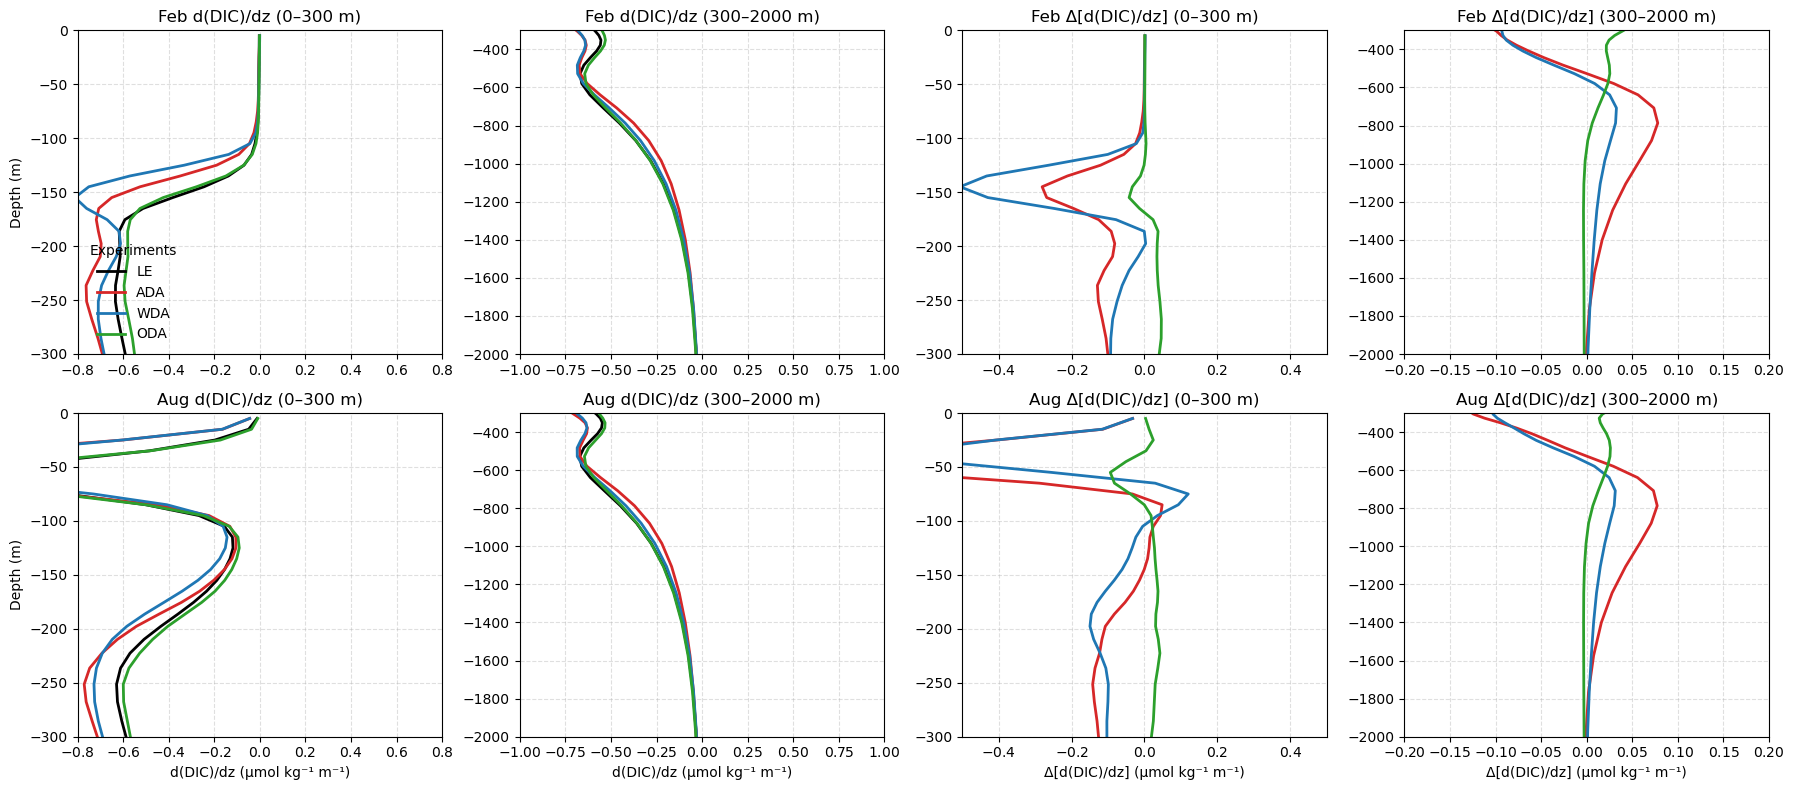

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ==========================================================
# 1) Helper: extract monthly-mean vertical gradient (dDIC/dz)
# ==========================================================
def extract_dic_vertical_gradient_monthlymean(ds_dic, lat_pt=31, lon_range=(140, 165), depth_range=(0, -5000)):
    """
    Compute monthly mean vertical DIC gradient (dDIC/dz, µmol kg⁻¹/m)
    using z_t (m, negative downward)
    """
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)  # cm→m, flip sign (upward positive)
    da = ds_dic.sel(lat=lat_pt, method="nearest").sel(lon=slice(*lon_range)).sel(z_t=slice(*depth_range))

    # NaN-safe lon mean
    valid_mask = da.notnull().all(dim="lon")
    mean_val = da.mean(dim="lon", skipna=False)
    mean_val = mean_val.where(valid_mask)

    # --- vertical gradient dDIC/dz (µmol/kg per m)
    dDICdz = np.gradient(mean_val, mean_val["z_t"], axis=mean_val.get_axis_num("z_t"))

    da_grad = mean_val.copy(data=dDICdz)
    da_grad.attrs["units"] = "µmol kg⁻¹/m"
    return da_grad.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
vert_LE  = extract_dic_vertical_gradient_monthlymean(cfg_var_DIC.LE_ds_rgd)
vert_ADA = extract_dic_vertical_gradient_monthlymean(cfg_var_DIC.ADA_ds_rgd)
vert_WDA = extract_dic_vertical_gradient_monthlymean(cfg_var_DIC.WDA_ds_rgd)
vert_ODA = extract_dic_vertical_gradient_monthlymean(cfg_var_DIC.ODA_ds_rgd)

Feb_profiles = {k: v.sel(month=2) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {"LE": vert_LE, "ADA": vert_ADA, "WDA": vert_WDA, "ODA": vert_ODA}.items()}

# ==========================================================
# 3) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}

# ==========================================================
# 4) Plot: 2×4 panels (0–300 m, 300–2000 m only)
# ==========================================================
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8), sharey=False)
colors_main = ["k", "C3", "C0", "C2"]
colors_diff = ["C3", "C0", "C2"]

titles_Feb = [
    "Feb d(DIC)/dz (0–300 m)",
    "Feb d(DIC)/dz (300–2000 m)",
    "Feb Δ[d(DIC)/dz] (0–300 m)",
    "Feb Δ[d(DIC)/dz] (300–2000 m)"
]
for j in range(4):
    axes[0, j].set_title(titles_Feb[j])

# ---------- (1행) February ----------
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[0,1].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2)
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[0,2].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)
    axes[0,3].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)

# ---------- (2행) August ----------
titles_Aug = [
    "Aug d(DIC)/dz (0–300 m)",
    "Aug d(DIC)/dz (300–2000 m)",
    "Aug Δ[d(DIC)/dz] (0–300 m)",
    "Aug Δ[d(DIC)/dz] (300–2000 m)"
]
for j in range(4):
    axes[1, j].set_title(titles_Aug[j])

for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,0].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[1,1].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2)
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[1,2].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)
    axes[1,3].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)

# ---------- 공통 축 설정 ----------
for i in range(2):
    for j in range(4):
        axes[i, j].grid(True, ls="--", alpha=0.4)

# Depth 범위
axes[0,0].set_ylim(-300, 0)
axes[1,0].set_ylim(-300, 0)
axes[0,1].set_ylim(-2000, -300)
axes[1,1].set_ylim(-2000, -300)
axes[0,2].set_ylim(-300, 0)
axes[1,2].set_ylim(-300, 0)
axes[0,3].set_ylim(-2000, -300)
axes[1,3].set_ylim(-2000, -300)

# X범위 (dDIC/dz typical scale: µmol/kg/m)
axes[0,0].set_xlim(-0.8, 0.8)
axes[1,0].set_xlim(-0.8, 0.8)
axes[0,1].set_xlim(-1, 1)
axes[1,1].set_xlim(-1, 1)
axes[0,2].set_xlim(-0.5, 0.5)
axes[1,2].set_xlim(-0.5, 0.5)
axes[0,3].set_xlim(-0.2, 0.2)
axes[1,3].set_xlim(-0.2, 0.2)

# ---------- 지수 표기 ----------
for i in range(2):
    for j in range(4):
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 3))
        axes[i, j].xaxis.set_major_formatter(formatter)
        axes[i, j].ticklabel_format(axis='x', style='sci', scilimits=(-2, 3))

# ---------- Labels ----------
axes[1,0].set_xlabel("d(DIC)/dz (µmol kg⁻¹ m⁻¹)")
axes[1,1].set_xlabel("d(DIC)/dz (µmol kg⁻¹ m⁻¹)")
for j in [2, 3]:
    axes[1,j].set_xlabel("Δ[d(DIC)/dz] (µmol kg⁻¹ m⁻¹)")
axes[0,0].set_ylabel("Depth (m)")
axes[1,0].set_ylabel("Depth (m)")
axes[0,0].legend(loc="lower left", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ==========================================================
# 1) Helper: compute advective term −w * d(DIC)/dz
# ==========================================================
def compute_dic_vertical_advection(ds_dic, ds_wvel, lat_pt=31, lon_range=(140, 165), depth_range=(0, -5000)):
    """
    Compute monthly mean vertical DIC advection term: −w * d(DIC)/dz
    using:
      - DIC on z_t (cell center)
      - WVEL on z_w_top (cell interface)
    Returns: monthly mean (µmol kg⁻¹ m⁻¹ s⁻¹ equivalent)
    """
    # --- preprocess coordinates (cm→m, flip sign so depth positive downward) ---
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    ds_wvel = ds_wvel.assign_coords(z_w_top=-ds_wvel.z_w_top / 100.0)

    # --- select region ---
    da_dic = ds_dic.sel(lat=lat_pt, method="nearest").sel(lon=slice(*lon_range)).sel(z_t=slice(*depth_range))
    da_wvel = ds_wvel.sel(lat=lat_pt, method="nearest").sel(lon=slice(*lon_range)).sel(z_w_top=slice(*depth_range))

    # --- NaN-safe lon mean ---
    valid_dic = da_dic.notnull().all(dim="lon")
    valid_wvel = da_wvel.notnull().all(dim="lon")
    mean_dic = da_dic.mean(dim="lon", skipna=False).where(valid_dic)
    mean_wvel = da_wvel.mean(dim="lon", skipna=False).where(valid_wvel)

    # --- compute d(DIC)/dz (µmol kg⁻¹ m⁻¹) ---
    dDICdz = np.gradient(mean_dic, mean_dic["z_t"], axis=mean_dic.get_axis_num("z_t"))
    da_dDICdz = mean_dic.copy(data=dDICdz)
    da_dDICdz.attrs["units"] = "µmol kg⁻¹ m⁻¹"

    # --- interpolate wvel from z_w_top → z_t (cell-center position) ---
    w_center = mean_wvel.interp(z_w_top=mean_dic["z_t"])

    # --- compute advective term: −w * d(DIC)/dz ---
    adv_term = -w_center * da_dDICdz
    adv_term.attrs["long_name"] = "Vertical advective DIC tendency"
    adv_term.attrs["units"] = "µmol kg⁻¹ m⁻¹ s⁻¹ (up to scaling)"

    # --- monthly mean ---
    adv_monthly = adv_term.groupby("time.month").mean(dim="time")

    return adv_monthly


# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
adv_LE  = compute_dic_vertical_advection(cfg_var_DIC.LE_ds_rgd,  cfg_var_WVEL.LE_ds_rgd)
adv_ADA = compute_dic_vertical_advection(cfg_var_DIC.ADA_ds_rgd, cfg_var_WVEL.ADA_ds_rgd)
adv_WDA = compute_dic_vertical_advection(cfg_var_DIC.WDA_ds_rgd, cfg_var_WVEL.WDA_ds_rgd)
adv_ODA = compute_dic_vertical_advection(cfg_var_DIC.ODA_ds_rgd, cfg_var_WVEL.ODA_ds_rgd)

Feb_profiles = {k: v.sel(month=2) for k, v in {
    "LE": adv_LE, "ADA": adv_ADA, "WDA": adv_WDA, "ODA": adv_ODA}.items()}
Aug_profiles = {k: v.sel(month=8) for k, v in {
    "LE": adv_LE, "ADA": adv_ADA, "WDA": adv_WDA, "ODA": adv_ODA}.items()}

# ==========================================================
# 3) Compute mean differences (Exp − LE)
# ==========================================================
diff_Feb = {
    "ADA−LE": Feb_profiles["ADA"] - Feb_profiles["LE"],
    "WDA−LE": Feb_profiles["WDA"] - Feb_profiles["LE"],
    "ODA−LE": Feb_profiles["ODA"] - Feb_profiles["LE"],
}
diff_Aug = {
    "ADA−LE": Aug_profiles["ADA"] - Aug_profiles["LE"],
    "WDA−LE": Aug_profiles["WDA"] - Aug_profiles["LE"],
    "ODA−LE": Aug_profiles["ODA"] - Aug_profiles["LE"],
}


# ==========================================================
# 4) Plot: 2×4 panels (0–300 m, 300–2000 m)
# ==========================================================
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8), sharey=False)
colors_main = ["k", "C3", "C0", "C2"]
colors_diff = ["C3", "C0", "C2"]

# ---------- (1행) February ----------
titles_Feb = [
    "Feb −w·∂DIC/∂z (0–300 m)",
    "Feb −w·∂DIC/∂z (300–2000 m)",
    "Feb Δ(−w·∂DIC/∂z) (0–300 m)",
    "Feb Δ(−w·∂DIC/∂z) (300–2000 m)"
]
for j in range(4):
    axes[0, j].set_title(titles_Feb[j])

# Mean panels
for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[0,0].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[0,1].plot(Feb_profiles[label], Feb_profiles[label]["z_t"], color=color, lw=2)
# Diff panels
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[0,2].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)
    axes[0,3].plot(diff_Feb[label], diff_Feb[label]["z_t"], color=color, lw=2)

# ---------- (2행) August ----------
titles_Aug = [
    "Aug −w·∂DIC/∂z (0–300 m)",
    "Aug −w·∂DIC/∂z (300–2000 m)",
    "Aug Δ(−w·∂DIC/∂z) (0–300 m)",
    "Aug Δ(−w·∂DIC/∂z) (300–2000 m)"
]
for j in range(4):
    axes[1, j].set_title(titles_Aug[j])

for label, color in zip(["LE", "ADA", "WDA", "ODA"], colors_main):
    axes[1,0].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2, label=label)
    axes[1,1].plot(Aug_profiles[label], Aug_profiles[label]["z_t"], color=color, lw=2)
for label, color in zip(["ADA−LE", "WDA−LE", "ODA−LE"], colors_diff):
    axes[1,2].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)
    axes[1,3].plot(diff_Aug[label], diff_Aug[label]["z_t"], color=color, lw=2)

# ---------- 공통 축 설정 ----------
for i in range(2):
    for j in range(4):
        axes[i, j].grid(True, ls="--", alpha=0.4)

# Depth 범위
axes[0,0].set_ylim(-300, 0)
axes[1,0].set_ylim(-300, 0)
axes[0,1].set_ylim(-2000, -300)
axes[1,1].set_ylim(-2000, -300)
axes[0,2].set_ylim(-300, 0)
axes[1,2].set_ylim(-300, 0)
axes[0,3].set_ylim(-2000, -300)
axes[1,3].set_ylim(-2000, -300)

# X범위 (scale estimate)
axes[0,0].set_xlim(-1e-4, 1e-4)
axes[1,0].set_xlim(-1e-4, 1e-4)
axes[0,1].set_xlim(-5e-5, 5e-5)
axes[1,1].set_xlim(-5e-5, 5e-5)
axes[0,2].set_xlim(-5e-5, 5e-5)
axes[1,2].set_xlim(-5e-5, 5e-5)
axes[0,3].set_xlim(-5e-5, 5e-5)
axes[1,3].set_xlim(-5e-5, 5e-5)

# ---------- 지수 표기 ----------
for i in range(2):
    for j in range(4):
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-3, 3))
        axes[i, j].xaxis.set_major_formatter(formatter)
        axes[i, j].ticklabel_format(axis='x', style='sci', scilimits=(-3, 3))

# ---------- Labels ----------
axes[1,0].set_xlabel("−w·∂DIC/∂z (µmol kg⁻¹ m⁻¹ s⁻¹)")
axes[1,1].set_xlabel("−w·∂DIC/∂z (µmol kg⁻¹ m⁻¹ s⁻¹)")
for j in [2, 3]:
    axes[1,j].set_xlabel("Δ(−w·∂DIC/∂z) (µmol kg⁻¹ m⁻¹ s⁻¹)")
axes[0,0].set_ylabel("Depth (m)")
axes[1,0].set_ylabel("Depth (m)")

axes[0,0].legend(loc="lower left", frameon=False, title="Experiments")

plt.tight_layout()
plt.show()


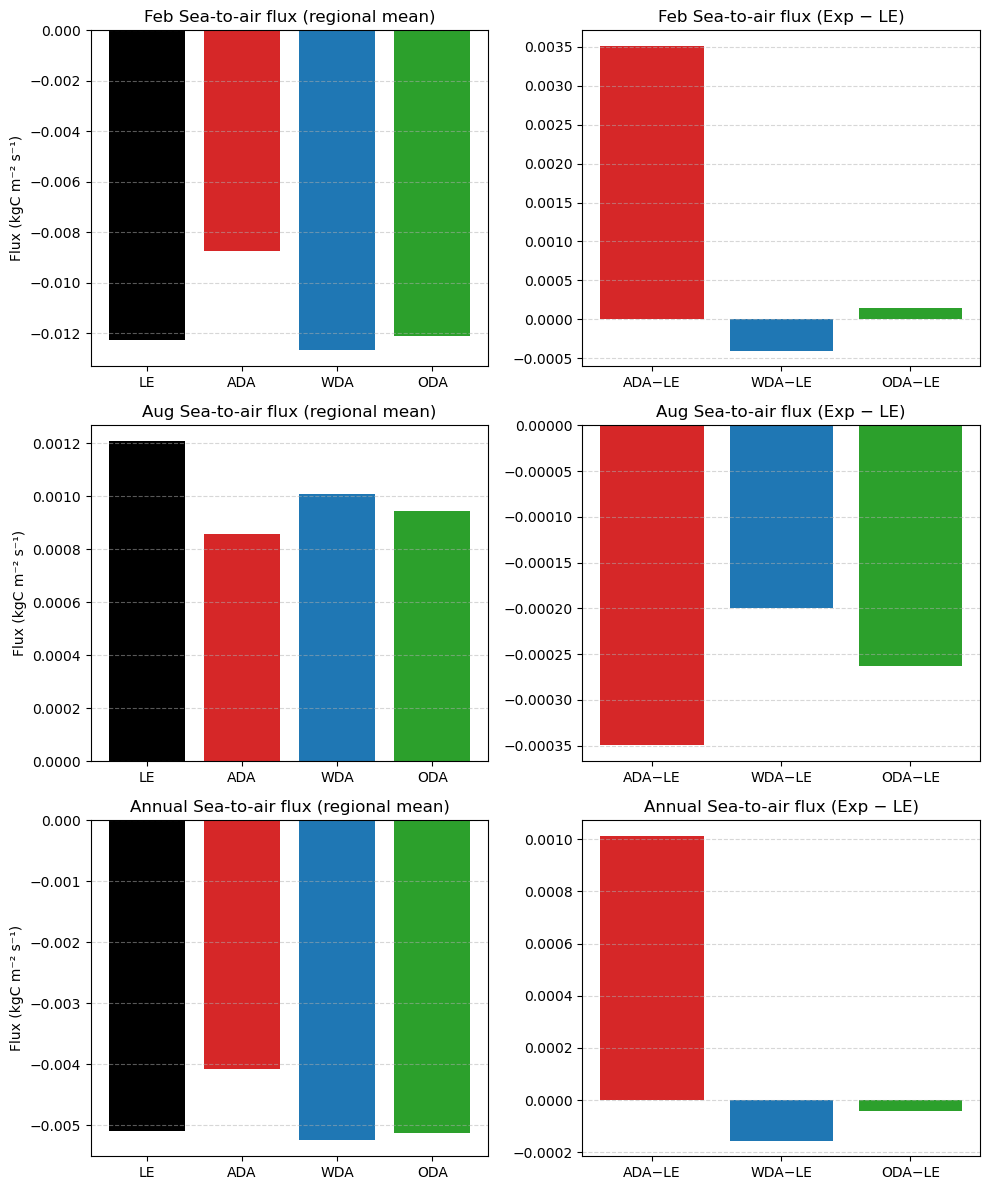

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: Extract regional monthly mean FG_CO2
# ==========================================================
def extract_fgco2_monthlymean(ds_fg, lat_pt=31, lon_range=(140, 165)):
    """
    Extract monthly mean FG_CO2 (air–sea CO₂ flux)
    Positive upward (ocean → atmosphere).
    """
    da = ds_fg.sel(lat=lat_pt, method="nearest").sel(lon=slice(*lon_range))
    valid_mask = da.notnull().all(dim="lon")
    mean_val = da.mean(dim="lon", skipna=False).where(valid_mask)
    return mean_val.groupby("time.month").mean(dim="time")


# ==========================================================
# 2) Extract data for each simulation
# ==========================================================
fg_LE  = extract_fgco2_monthlymean(-cfg_var_FG_CO2.LE_ds_rgd)
fg_ADA = extract_fgco2_monthlymean(-cfg_var_FG_CO2.ADA_ds_rgd)
fg_WDA = extract_fgco2_monthlymean(-cfg_var_FG_CO2.WDA_ds_rgd)
fg_ODA = extract_fgco2_monthlymean(-cfg_var_FG_CO2.ODA_ds_rgd)

# ==========================================================
# 3) Compute Feb / Aug / Annual mean values
# ==========================================================
FG_Feb = {k: float(v.sel(month=2)) for k, v in {"LE": fg_LE, "ADA": fg_ADA, "WDA": fg_WDA, "ODA": fg_ODA}.items()}
FG_Aug = {k: float(v.sel(month=8)) for k, v in {"LE": fg_LE, "ADA": fg_ADA, "WDA": fg_WDA, "ODA": fg_ODA}.items()}
FG_Ann = {k: float(v.mean(dim="month")) for k, v in {"LE": fg_LE, "ADA": fg_ADA, "WDA": fg_WDA, "ODA": fg_ODA}.items()}

# ==========================================================
# 4) Compute differences (Exp − LE)
# ==========================================================
def compute_diff(dic):
    return {
        "ADA−LE": dic["ADA"] - dic["LE"],
        "WDA−LE": dic["WDA"] - dic["LE"],
        "ODA−LE": dic["ODA"] - dic["LE"],
    }

diff_Feb = compute_diff(FG_Feb)
diff_Aug = compute_diff(FG_Aug)
diff_Ann = compute_diff(FG_Ann)

# ==========================================================
# 5) Plot bar chart (3×2 panels: Feb, Aug, Annual)
# ==========================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

exps = ["LE", "ADA", "WDA", "ODA"]
diffs = ["ADA−LE", "WDA−LE", "ODA−LE"]
colors = ["k", "C3", "C0", "C2"]

# ========== February ==========
axes[0,0].bar(exps, [FG_Feb[k] for k in exps], color=colors)
axes[0,0].set_title("Feb Sea-to-air flux (regional mean)")
axes[0,0].set_ylabel("Flux (kgC m⁻² s⁻¹)")

axes[0,1].bar(diffs, [diff_Feb[k] for k in diffs], color=["C3", "C0", "C2"])
axes[0,1].set_title("Feb Sea-to-air flux (Exp − LE)")

# ========== August ==========
axes[1,0].bar(exps, [FG_Aug[k] for k in exps], color=colors)
axes[1,0].set_title("Aug Sea-to-air flux (regional mean)")
axes[1,0].set_ylabel("Flux (kgC m⁻² s⁻¹)")

axes[1,1].bar(diffs, [diff_Aug[k] for k in diffs], color=["C3", "C0", "C2"])
axes[1,1].set_title("Aug Sea-to-air flux (Exp − LE)")

# ========== Annual ==========
axes[2,0].bar(exps, [FG_Ann[k] for k in exps], color=colors)
axes[2,0].set_title("Annual Sea-to-air flux (regional mean)")
axes[2,0].set_ylabel("Flux (kgC m⁻² s⁻¹)")

axes[2,1].bar(diffs, [diff_Ann[k] for k in diffs], color=["C3", "C0", "C2"])
axes[2,1].set_title("Annual Sea-to-air flux (Exp − LE)")

# ========== Formatting ==========
for i in range(3):
    for j in range(2):
        axes[i,j].grid(axis="y", ls="--", alpha=0.5)
        axes[i,j].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


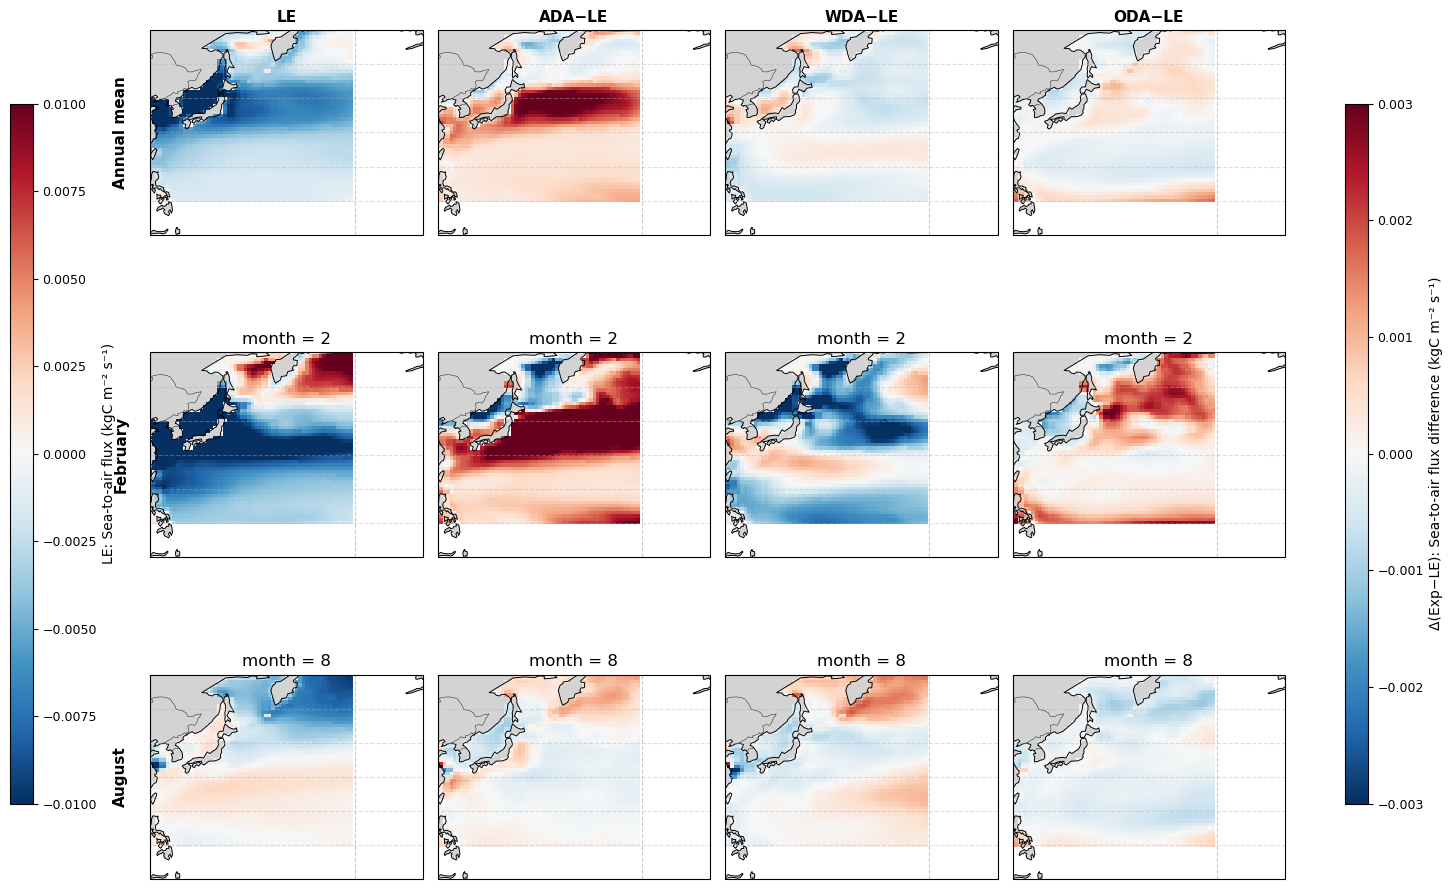

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ==========================================================
# 1) Helper: Extract monthly mean FG_CO2 field
# ==========================================================
def extract_fgco2_monthlymean(ds_fg):
    """Compute monthly climatology of FG_CO2 (kgC/m²/s).
    Positive upward (ocean → atmosphere)."""
    return ds_fg.groupby("time.month").mean(dim="time")

# ==========================================================
# 2) Prepare monthly climatology for each simulation
# ==========================================================
fg_LE  = extract_fgco2_monthlymean(-cfg_var_FG_CO2.LE_ds_rgd)
fg_ADA = extract_fgco2_monthlymean(-cfg_var_FG_CO2.ADA_ds_rgd)
fg_WDA = extract_fgco2_monthlymean(-cfg_var_FG_CO2.WDA_ds_rgd)
fg_ODA = extract_fgco2_monthlymean(-cfg_var_FG_CO2.ODA_ds_rgd)

# ==========================================================
# 3) Compute Annual, Feb, Aug means
# ==========================================================
fg_Ann = { "LE": fg_LE.mean(dim="month"),
           "ADA−LE": fg_ADA.mean(dim="month") - fg_LE.mean(dim="month"),
           "WDA−LE": fg_WDA.mean(dim="month") - fg_LE.mean(dim="month"),
           "ODA−LE": fg_ODA.mean(dim="month") - fg_LE.mean(dim="month") }

fg_Feb = { "LE": fg_LE.sel(month=2),
           "ADA−LE": fg_ADA.sel(month=2) - fg_LE.sel(month=2),
           "WDA−LE": fg_WDA.sel(month=2) - fg_LE.sel(month=2),
           "ODA−LE": fg_ODA.sel(month=2) - fg_LE.sel(month=2) }

fg_Aug = { "LE": fg_LE.sel(month=8),
           "ADA−LE": fg_ADA.sel(month=8) - fg_LE.sel(month=8),
           "WDA−LE": fg_WDA.sel(month=8) - fg_LE.sel(month=8),
           "ODA−LE": fg_ODA.sel(month=8) - fg_LE.sel(month=8) }

# ==========================================================
# 4) Plot: 3×4 horizontal maps (vertical colorbars)
# ==========================================================
proj = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(
    nrows=3, ncols=4,
    figsize=(15, 10),
    subplot_kw={"projection": proj}
)

# ---- ✅ Color scale (고정값 유지) ----
vmin_base, vmax_base = -1e-2, 1e-2    # LE flux range
vmin_diff, vmax_diff = -3e-3, 3e-3    # difference range

months = ["Annual mean", "February", "August"]
datasets = [fg_Ann, fg_Feb, fg_Aug]
titles_col = ["LE", "ADA−LE", "WDA−LE", "ODA−LE"]

# mappables 저장용
pcm_LE = None
pcm_DIFF = None

# ---- Plotting ----
for i, (label_row, data_group) in enumerate(zip(months, datasets)):
    for j, key in enumerate(["LE", "ADA−LE", "WDA−LE", "ODA−LE"]):
        ax = axes[i, j]
        ax.set_extent([120, 200, 0, 60], crs=ccrs.PlateCarree())
        ax.coastlines(resolution="110m", lw=0.7)
        ax.add_feature(cfeature.BORDERS, lw=0.3)
        ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=-1)
        ax.gridlines(draw_labels=False, linestyle="--", alpha=0.4)

        if key == "LE":
            pcm = data_group[key].plot(
                ax=ax, transform=ccrs.PlateCarree(),
                cmap="RdBu_r", vmin=vmin_base, vmax=vmax_base,
                add_colorbar=False
            )
            if pcm_LE is None:
                pcm_LE = pcm  # 첫 번째 LE 패널 저장
        else:
            pcm = data_group[key].plot(
                ax=ax, transform=ccrs.PlateCarree(),
                cmap="RdBu_r", vmin=vmin_diff, vmax=vmax_diff,
                add_colorbar=False
            )
            if pcm_DIFF is None:
                pcm_DIFF = pcm  # 첫 번째 Diff 패널 저장

        if i == 0:
            ax.set_title(titles_col[j], fontsize=11, fontweight="bold")
        if j == 0:
            ax.text(-0.08, 0.5, label_row, va="center", ha="right",
                    rotation=90, transform=ax.transAxes,
                    fontsize=11, fontweight="bold")

# ==========================================================
# 5) Colorbars (왼쪽/오른쪽 vertical)
# ==========================================================
# 왼쪽: LE flux colorbar
cbar_ax1 = fig.add_axes([0.04, 0.15, 0.015, 0.7])
cbar1 = fig.colorbar(pcm_LE, cax=cbar_ax1, orientation="vertical")
cbar1.set_label("LE: Sea-to-air flux (kgC m⁻² s⁻¹)", fontsize=10)
cbar1.ax.tick_params(labelsize=9)

# 오른쪽: Δ(Exp−LE) colorbar
cbar_ax2 = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cbar2 = fig.colorbar(pcm_DIFF, cax=cbar_ax2, orientation="vertical")
cbar2.set_label("Δ(Exp−LE): Sea-to-air flux difference (kgC m⁻² s⁻¹)", fontsize=10)
cbar2.ax.tick_params(labelsize=9)

plt.tight_layout(rect=[0.1, 0, 0.9, 1])
plt.show()


Selected grid info:
LE  : lon=155.00,  lat=31.00,  z_t=-197.7 m
ADA : lon=155.00, lat=31.00, z_t=-197.7 m
WDA : lon=155.00, lat=31.00, z_t=-197.7 m
ODA : lon=155.00, lat=31.00, z_t=-197.7 m


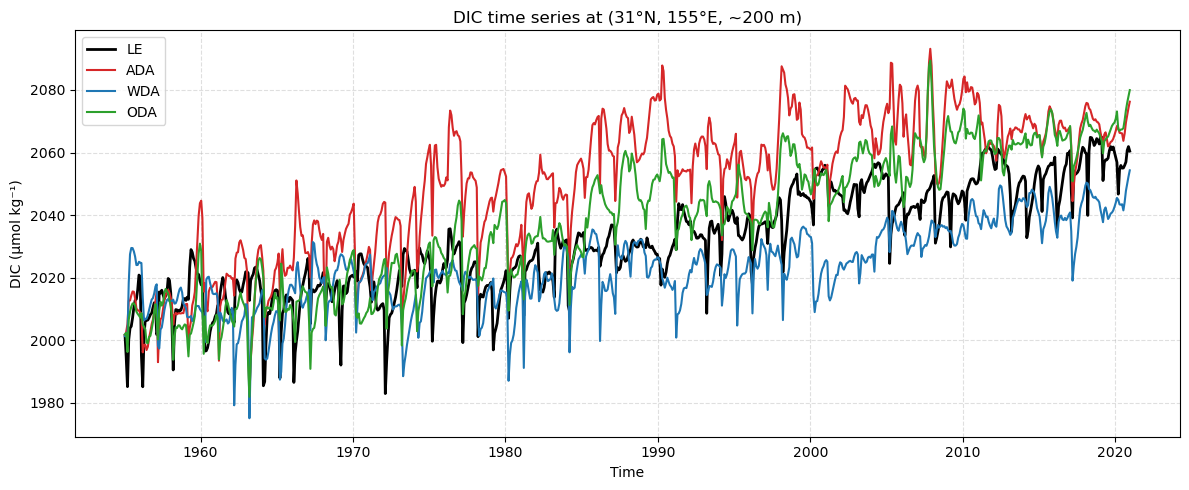

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# 1) Helper: convert CFTime → datetime64
# ==========================================================
def convert_cftime_to_datetime(da):
    """Safely convert cftime.DatetimeNoLeap to numpy.datetime64 for plotting."""
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array(
        [np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values]
    )
    return da

# ==========================================================
# 2) Helper: extract single-point DIC time series
# ==========================================================
def extract_dic_point(ds_dic, lat_pt=31, lon_pt=155, depth_pt=-200):
    """
    Extract DIC time series at a specific point (nearest grid).
    Depth unit converted from cm→m and sign flipped.
    """
    # Convert z_t to m (positive down)
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    
    # Select nearest point
    da_point = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=depth_pt, method="nearest")
    )
    return da_point

# ==========================================================
# 3) Extract time series for all datasets
# ==========================================================
ts_LE  = extract_dic_point(cfg_var_DIC.LE_ds_rgd)
ts_ADA = extract_dic_point(cfg_var_DIC.ADA_ds_rgd)
ts_WDA = extract_dic_point(cfg_var_DIC.WDA_ds_rgd)
ts_ODA = extract_dic_point(cfg_var_DIC.ODA_ds_rgd)

# Convert CFTime to datetime
ts_LE  = convert_cftime_to_datetime(ts_LE)
ts_ADA = convert_cftime_to_datetime(ts_ADA)
ts_WDA = convert_cftime_to_datetime(ts_WDA)
ts_ODA = convert_cftime_to_datetime(ts_ODA)

# ==========================================================
# 4) Print info to verify selection
# ==========================================================
print("Selected grid info:")
print(f"LE  : lon={float(ts_LE.lon.values):.2f},  lat={float(ts_LE.lat.values):.2f},  z_t={float(ts_LE.z_t.values):.1f} m")
print(f"ADA : lon={float(ts_ADA.lon.values):.2f}, lat={float(ts_ADA.lat.values):.2f}, z_t={float(ts_ADA.z_t.values):.1f} m")
print(f"WDA : lon={float(ts_WDA.lon.values):.2f}, lat={float(ts_WDA.lat.values):.2f}, z_t={float(ts_WDA.z_t.values):.1f} m")
print(f"ODA : lon={float(ts_ODA.lon.values):.2f}, lat={float(ts_ODA.lat.values):.2f}, z_t={float(ts_ODA.z_t.values):.1f} m")

# ==========================================================
# 5) Plot time series
# ==========================================================
plt.figure(figsize=(12, 5))
plt.plot(ts_LE.time,  ts_LE,  label="LE",  color="k", lw=2)
plt.plot(ts_ADA.time, ts_ADA, label="ADA", color="C3")
plt.plot(ts_WDA.time, ts_WDA, label="WDA", color="C0")
plt.plot(ts_ODA.time, ts_ODA, label="ODA", color="C2")

plt.title("DIC time series at (31°N, 155°E, ~200 m)")
plt.ylabel("DIC (µmol kg⁻¹)")
plt.xlabel("Time")
plt.legend()
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [85]:
import xarray as xr
import os

# ----------------------------------------------------------
# 1. 기본 경로 설정
# ----------------------------------------------------------
base_dir = "/proj/kimyy/tr_sysong"

files = {
    "AVISO":  "AVISO_KE_SSH_1993to2022.nc",
    "REANAL": "REANAL_KE_SSH_1958to2022.nc",
    "STMWV":  "STMWV_1958to2017.nc",
}

# ----------------------------------------------------------
# 2. 파일 열기 (xarray)
# ----------------------------------------------------------
ds = {}
for key, fname in files.items():
    path = os.path.join(base_dir, fname)
    if os.path.exists(path):
        ds[key] = xr.open_dataset(path)
        print(f"✅ Loaded: {key}  |  variables: {list(ds[key].data_vars)}")
    else:
        print(f"❌ File not found: {path}")

# ----------------------------------------------------------
# 3. 각 파일의 기본 구조 확인
# ----------------------------------------------------------
for key in ds:
    print(f"\n===== {key} =====")
    print(ds[key])

✅ Loaded: AVISO  |  variables: ['AVISO_KE_SSH']
✅ Loaded: REANAL  |  variables: ['OFES1_KE_SSH', 'OFES2_KE_SSH', 'ORAS5_KE_SSH']
✅ Loaded: STMWV  |  variables: ['PD7_STMWV', 'ADA_STMWV', 'ODA_STMWV', 'WDA_STMWV', 'LE2_STMWV']

===== AVISO =====
<xarray.Dataset> Size: 9kB
Dimensions:       (time: 360)
Coordinates:
  * time          (time) datetime64[ns] 3kB 1993-01-31 1993-02-28 ... 2022-12-31
    month         (time) int64 3kB ...
Data variables:
    AVISO_KE_SSH  (time) float64 3kB ...

===== REANAL =====
<xarray.Dataset> Size: 31kB
Dimensions:       (time: 780)
Coordinates:
  * time          (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2022-12-31
    month         (time) int64 6kB ...
Data variables:
    OFES1_KE_SSH  (time) float64 6kB ...
    OFES2_KE_SSH  (time) float64 6kB ...
    ORAS5_KE_SSH  (time) float64 6kB ...

===== STMWV =====
<xarray.Dataset> Size: 887kB
Dimensions:    (time: 720, ens: 50)
Coordinates:
  * time       (time) datetime64[ns] 6kB 1958-01-31 1958-02-2

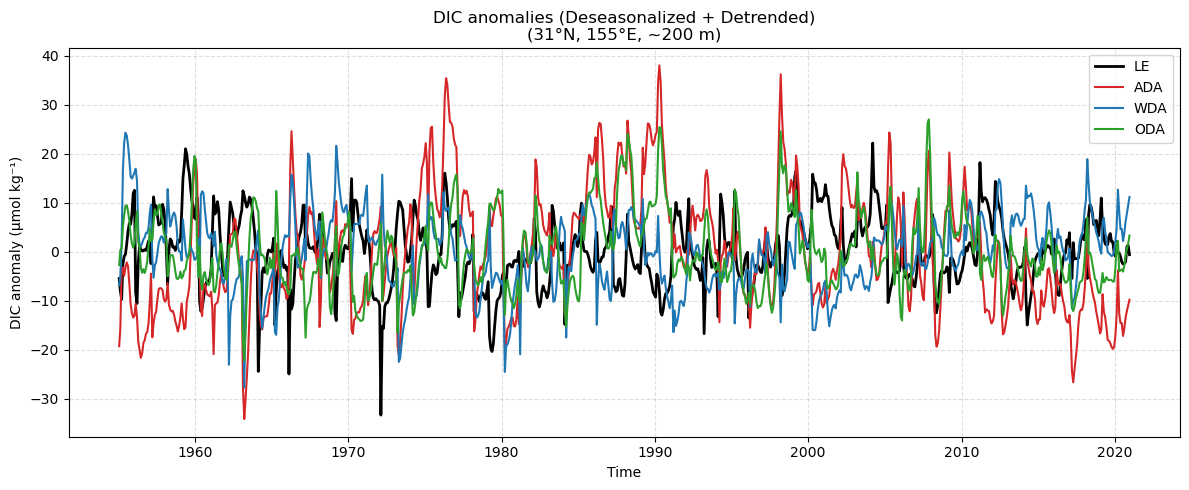

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import linregress
import pandas as pd

# ==========================================================
# 1) Helper: convert CFTime → datetime64
# ==========================================================
def convert_cftime_to_datetime(da):
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array(
        [np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values]
    )
    return da

# ==========================================================
# 2) Helper: extract single-point DIC time series
# ==========================================================
def extract_dic_point(ds_dic, lat_pt=31, lon_pt=155, depth_pt=-200):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da_point = (
        ds_dic
        .sel(lat=lat_pt, lon=lon_pt, method="nearest")
        .sel(z_t=depth_pt, method="nearest")
    )
    return da_point

# ==========================================================
# 3) Helper: remove seasonal cycle + linear trend
# ==========================================================
def deseasonalize_detrend(da):
    """Remove monthly climatology and linear trend."""
    da = convert_cftime_to_datetime(da)
    df = pd.Series(da.values, index=pd.to_datetime(da.time.values))

    # (1) Remove monthly climatology (seasonal cycle)
    monthly_clim = df.groupby(df.index.month).transform(lambda x: x - x.mean())

    # (2) Remove linear trend
    x = np.arange(len(monthly_clim))
    slope, intercept, *_ = linregress(x, monthly_clim.values)
    detrended = monthly_clim - (slope * x + intercept)

    return detrended, df.index

# ==========================================================
# 4) Extract and process time series
# ==========================================================
ts_LE_raw  = extract_dic_point(cfg_var_DIC.LE_ds_rgd)
ts_ADA_raw = extract_dic_point(cfg_var_DIC.ADA_ds_rgd)
ts_WDA_raw = extract_dic_point(cfg_var_DIC.WDA_ds_rgd)
ts_ODA_raw = extract_dic_point(cfg_var_DIC.ODA_ds_rgd)

ts_LE, time = deseasonalize_detrend(ts_LE_raw)
ts_ADA, _   = deseasonalize_detrend(ts_ADA_raw)
ts_WDA, _   = deseasonalize_detrend(ts_WDA_raw)
ts_ODA, _   = deseasonalize_detrend(ts_ODA_raw)

# ==========================================================
# 5) Plot
# ==========================================================
plt.figure(figsize=(12,5))
plt.plot(time, ts_LE,  label="LE",  color="k", lw=2)
plt.plot(time, ts_ADA, label="ADA", color="C3")
plt.plot(time, ts_WDA, label="WDA", color="C0")
plt.plot(time, ts_ODA, label="ODA", color="C2")

plt.title("DIC anomalies (Deseasonalized + Detrended)\n(31°N, 155°E, ~200 m)")
plt.ylabel("DIC anomaly (µmol kg⁻¹)")
plt.xlabel("Time")
plt.legend()
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


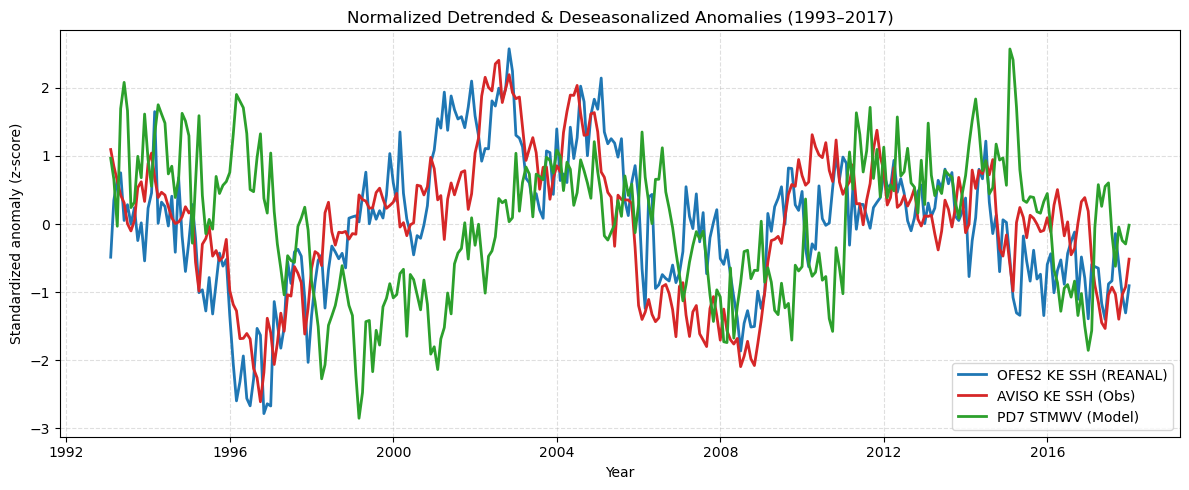

In [88]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ==========================================================
# 1) Load datasets
# ==========================================================
AVISO = xr.open_dataset("/proj/kimyy/tr_sysong/AVISO_KE_SSH_1993to2022.nc")
REANAL = xr.open_dataset("/proj/kimyy/tr_sysong/REANAL_KE_SSH_1958to2022.nc")
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")

# ==========================================================
# 2) Extract time series
# ==========================================================
da_aviso = AVISO["AVISO_KE_SSH"]
da_ofes2 = REANAL["OFES2_KE_SSH"]
da_stmwv = STMWV["PD7_STMWV"]

# 공통 기간 (1993–2017)
start, end = "1993-01-01", "2017-12-31"
da_aviso = da_aviso.sel(time=slice(start, end))
da_ofes2 = da_ofes2.sel(time=slice(start, end))
da_stmwv = da_stmwv.sel(time=slice(start, end))

# ==========================================================
# 3) Helper: deseasonalize + detrend + normalize
# ==========================================================
def deseason_detrend_normalize(da):
    """Remove monthly climatology + linear trend, then z-score normalize."""
    df = pd.Series(da.values, index=pd.to_datetime(da.time.values))

    # (1) 계절주기 제거
    deseasoned = df.groupby(df.index.month).transform(lambda x: x - x.mean())

    # (2) 선형 추세 제거
    x = np.arange(len(deseasoned))
    slope, intercept, *_ = linregress(x, deseasoned.values)
    detrended = deseasoned - (slope * x + intercept)

    # (3) 표준화 (평균 0, 표준편차 1)
    normalized = (detrended - detrended.mean()) / detrended.std()

    return normalized, df.index

anom_aviso, t_aviso = deseason_detrend_normalize(da_aviso)
anom_ofes2, t_ofes2 = deseason_detrend_normalize(da_ofes2)
anom_stmwv, t_stmwv = deseason_detrend_normalize(da_stmwv)

# ==========================================================
# 4) Plot normalized anomalies
# ==========================================================
plt.figure(figsize=(12,5))

plt.plot(t_ofes2, anom_ofes2, color="C0", label="OFES2 KE SSH (REANAL)", lw=2)
plt.plot(t_aviso, anom_aviso, color="C3", label="AVISO KE SSH (Obs)", lw=2)
plt.plot(t_stmwv, anom_stmwv, color="C2", label="PD7 STMWV (Model)", lw=2)

plt.title("Normalized Detrended & Deseasonalized Anomalies (1993–2017)")
plt.ylabel("Standardized anomaly (z-score)")
plt.xlabel("Year")
plt.legend()
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


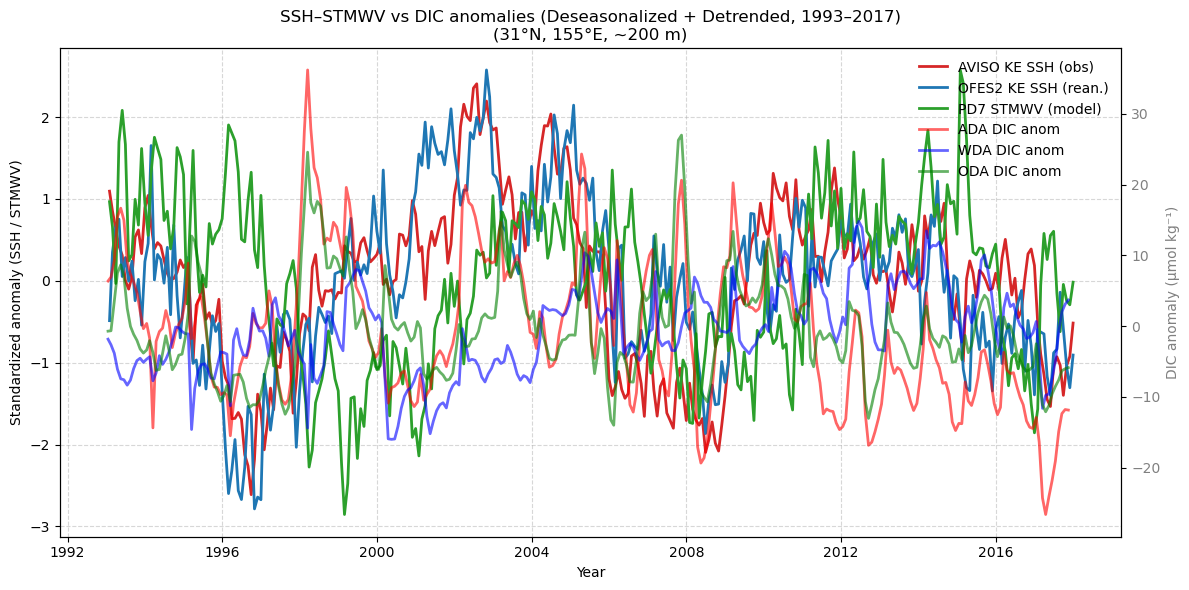

In [89]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ==========================================================
# 1) Load external datasets
# ==========================================================
AVISO = xr.open_dataset("/proj/kimyy/tr_sysong/AVISO_KE_SSH_1993to2022.nc")
REANAL = xr.open_dataset("/proj/kimyy/tr_sysong/REANAL_KE_SSH_1958to2022.nc")
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")

# ==========================================================
# 2) Extract KE/SSH time series (1993–2017)
# ==========================================================
da_aviso = AVISO["AVISO_KE_SSH"].sel(time=slice("1993-01", "2017-12"))
da_ofes2 = REANAL["OFES2_KE_SSH"].sel(time=slice("1993-01", "2017-12"))
da_stmwv = STMWV["PD7_STMWV"].sel(time=slice("1993-01", "2017-12"))

# ==========================================================
# 3) Deseason + detrend + normalize
# ==========================================================
def deseason_detrend_normalize(da):
    df = pd.Series(da.values, index=pd.to_datetime(da.time.values))
    deseason = df.groupby(df.index.month).transform(lambda x: x - x.mean())
    x = np.arange(len(deseason))
    slope, intercept, *_ = linregress(x, deseason.values)
    detrend = deseason - (slope * x + intercept)
    normed = (detrend - detrend.mean()) / detrend.std()
    return normed, df.index

anom_aviso, t_aviso = deseason_detrend_normalize(da_aviso)
anom_ofes2, _ = deseason_detrend_normalize(da_ofes2)
anom_stmwv, _ = deseason_detrend_normalize(da_stmwv)

# ==========================================================
# 4) Extract DIC anomalies (Deseasonalized + Detrended)
# ==========================================================
def convert_cftime_to_datetime(da):
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da

def extract_dic_point(ds_dic, lat_pt=31, lon_pt=155, depth_pt=-200):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da_point = ds_dic.sel(lat=lat_pt, lon=lon_pt, method="nearest").sel(z_t=depth_pt, method="nearest")
    return da_point

def deseasonalize_detrend(da):
    da = convert_cftime_to_datetime(da)
    df = pd.Series(da.values, index=pd.to_datetime(da.time.values))
    deseason = df.groupby(df.index.month).transform(lambda x: x - x.mean())
    x = np.arange(len(deseason))
    slope, intercept, *_ = linregress(x, deseason.values)
    detrended = deseason - (slope * x + intercept)
    return detrended, df.index

ts_ADA_raw = extract_dic_point(cfg_var_DIC.ADA_ds_rgd)
ts_WDA_raw = extract_dic_point(cfg_var_DIC.WDA_ds_rgd)
ts_ODA_raw = extract_dic_point(cfg_var_DIC.ODA_ds_rgd)

ts_ADA, time_dic = deseasonalize_detrend(ts_ADA_raw)
ts_WDA, _ = deseasonalize_detrend(ts_WDA_raw)
ts_ODA, _ = deseasonalize_detrend(ts_ODA_raw)

# 공통 구간 맞추기 (DIC 1993–2017로)
mask = (time_dic >= np.datetime64("1993-01")) & (time_dic <= np.datetime64("2017-12"))
time_dic = time_dic[mask]
ts_ADA = ts_ADA[mask]
ts_WDA = ts_WDA[mask]
ts_ODA = ts_ODA[mask]

# ==========================================================
# 5) Plot combined
# ==========================================================
fig, ax1 = plt.subplots(figsize=(12,6))

# --- left y-axis: normalized KE/STMWV anomalies ---
ax1.plot(t_aviso, anom_aviso, color="C3", label="AVISO KE SSH (obs)", lw=2)
ax1.plot(t_aviso, anom_ofes2, color="C0", label="OFES2 KE SSH (rean.)", lw=2)
ax1.plot(t_aviso, anom_stmwv, color="C2", label="PD7 STMWV (model)", lw=2)
ax1.set_ylabel("Standardized anomaly (SSH / STMWV)", color="k")
ax1.tick_params(axis='y', labelcolor='k')

# --- right y-axis: DIC anomalies ---
ax2 = ax1.twinx()
ax2.plot(time_dic, ts_ADA, color="r", alpha=0.6, lw=2, label="ADA DIC anom")
ax2.plot(time_dic, ts_WDA, color="b", alpha=0.6, lw=2, label="WDA DIC anom")
ax2.plot(time_dic, ts_ODA, color="g", alpha=0.6, lw=2, label="ODA DIC anom")
ax2.set_ylabel("DIC anomaly (µmol kg⁻¹)", color="gray")
ax2.tick_params(axis='y', labelcolor='gray')

# --- legend merge ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", frameon=False)

ax1.set_title("SSH–STMWV vs DIC anomalies (Deseasonalized + Detrended, 1993–2017)\n(31°N, 155°E, ~200 m)")
ax1.set_xlabel("Year")
ax1.grid(True, ls="--", alpha=0.5)

plt.tight_layout()
plt.show()


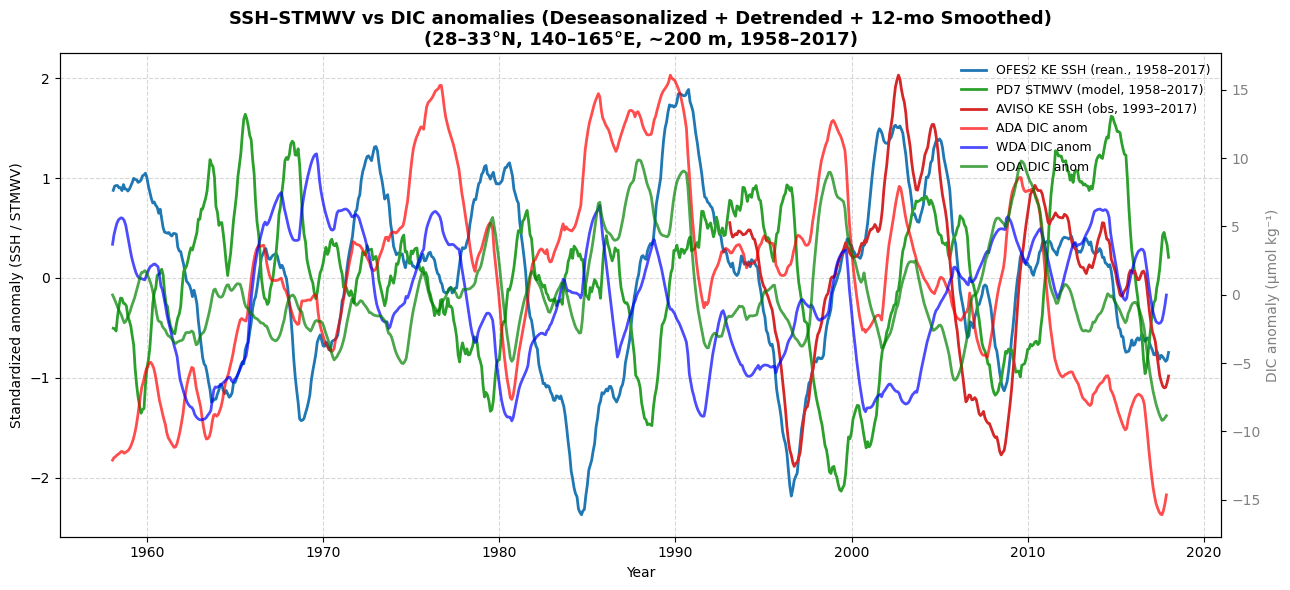

In [117]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ==========================================================
# 1) Load external datasets
# ==========================================================
AVISO = xr.open_dataset("/proj/kimyy/tr_sysong/AVISO_KE_SSH_1993to2022.nc")
REANAL = xr.open_dataset("/proj/kimyy/tr_sysong/REANAL_KE_SSH_1958to2022.nc")
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")

# ==========================================================
# 2) Extract KE/SSH time series (1958–2017)
# ==========================================================
da_aviso = AVISO["AVISO_KE_SSH"].sel(time=slice("1958-01", "2017-12"))
da_ofes2 = REANAL["OFES2_KE_SSH"].sel(time=slice("1958-01", "2017-12"))
da_stmwv = STMWV["PD7_STMWV"].sel(time=slice("1958-01", "2017-12"))

# ==========================================================
# 3) Deseason + detrend + normalize + 12mo smooth
# ==========================================================
def deseason_detrend_normalize(da):
    df = pd.Series(da.values, index=pd.to_datetime(da.time.values))
    # 계절성 제거
    deseason = df.groupby(df.index.month).transform(lambda x: x - x.mean())
    # 선형 추세 제거
    x = np.arange(len(deseason))
    slope, intercept, *_ = linregress(x, deseason.values)
    detrend = deseason - (slope * x + intercept)
    # 정규화
    normed = (detrend - detrend.mean()) / detrend.std()
    # 12개월 이동평균
    smooth = normed.rolling(window=12, center=True, min_periods=6).mean()
    return smooth, df.index

anom_aviso, t_aviso = deseason_detrend_normalize(da_aviso)
anom_ofes2, t_ofes2 = deseason_detrend_normalize(da_ofes2)
anom_stmwv, t_stmwv = deseason_detrend_normalize(da_stmwv)

# ==========================================================
# 4) Extract regional DIC anomalies (28–33N, 140–165E, 200 m)
# ==========================================================
def convert_cftime_to_datetime(da):
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da

def extract_dic_regmean(ds_dic, lat_rng=(28,33), lon_rng=(140,165), depth_pt=-200):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic.sel(lat=slice(*lat_rng), lon=slice(*lon_rng))
              .sel(z_t=depth_pt, method="nearest")
              .mean(dim=["lat", "lon"])
    )
    return convert_cftime_to_datetime(da)

def deseasonalize_detrend(da):
    df = pd.Series(da.values, index=pd.to_datetime(da.time.values))
    deseason = df.groupby(df.index.month).transform(lambda x: x - x.mean())
    x = np.arange(len(deseason))
    slope, intercept, *_ = linregress(x, deseason.values)
    detrended = deseason - (slope * x + intercept)
    smooth = detrended.rolling(window=12, center=True, min_periods=6).mean()
    return smooth, df.index

ts_ADA_raw = extract_dic_regmean(cfg_var_DIC.ADA_ds_rgd)
ts_WDA_raw = extract_dic_regmean(cfg_var_DIC.WDA_ds_rgd)
ts_ODA_raw = extract_dic_regmean(cfg_var_DIC.ODA_ds_rgd)

ts_ADA, time_dic = deseasonalize_detrend(ts_ADA_raw)
ts_WDA, _ = deseasonalize_detrend(ts_WDA_raw)
ts_ODA, _ = deseasonalize_detrend(ts_ODA_raw)

# --- 공통 구간 맞추기 (1958–2017) ---
mask = (time_dic >= np.datetime64("1958-01")) & (time_dic <= np.datetime64("2017-12"))
time_dic = time_dic[mask]
ts_ADA = ts_ADA[mask]
ts_WDA = ts_WDA[mask]
ts_ODA = ts_ODA[mask]

# ==========================================================
# 5) Plot combined (1958–2017, 12mo-smoothed)
# ==========================================================
fig, ax1 = plt.subplots(figsize=(13,6))

# --- left y-axis: normalized KE/STMWV anomalies ---
ax1.plot(t_ofes2, anom_ofes2, color="C0", lw=2, label="OFES2 KE SSH (rean., 1958–2017)")
ax1.plot(t_stmwv, anom_stmwv, color="C2", lw=2, label="PD7 STMWV (model, 1958–2017)")
ax1.plot(t_aviso, anom_aviso, color="C3", lw=2, label="AVISO KE SSH (obs, 1993–2017)")

ax1.set_ylabel("Standardized anomaly (SSH / STMWV)", color="k")
ax1.tick_params(axis='y', labelcolor='k')

# --- right y-axis: DIC anomalies ---
ax2 = ax1.twinx()
ax2.plot(time_dic, ts_ADA, color="r", alpha=0.7, lw=2, label="ADA DIC anom")
ax2.plot(time_dic, ts_WDA, color="b", alpha=0.7, lw=2, label="WDA DIC anom")
ax2.plot(time_dic, ts_ODA, color="g", alpha=0.7, lw=2, label="ODA DIC anom")
ax2.set_ylabel("DIC anomaly (µmol kg⁻¹)", color="gray")
ax2.tick_params(axis='y', labelcolor='gray')

# --- legend merge ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", frameon=False, fontsize=9)

ax1.set_title(
    "SSH–STMWV vs DIC anomalies (Deseasonalized + Detrended + 12-mo Smoothed)\n"
    "(28–33°N, 140–165°E, ~200 m, 1958–2017)",
    fontsize=13, fontweight="bold"
)
ax1.set_xlabel("Year")
ax1.grid(True, ls="--", alpha=0.5)

plt.tight_layout()
plt.show()


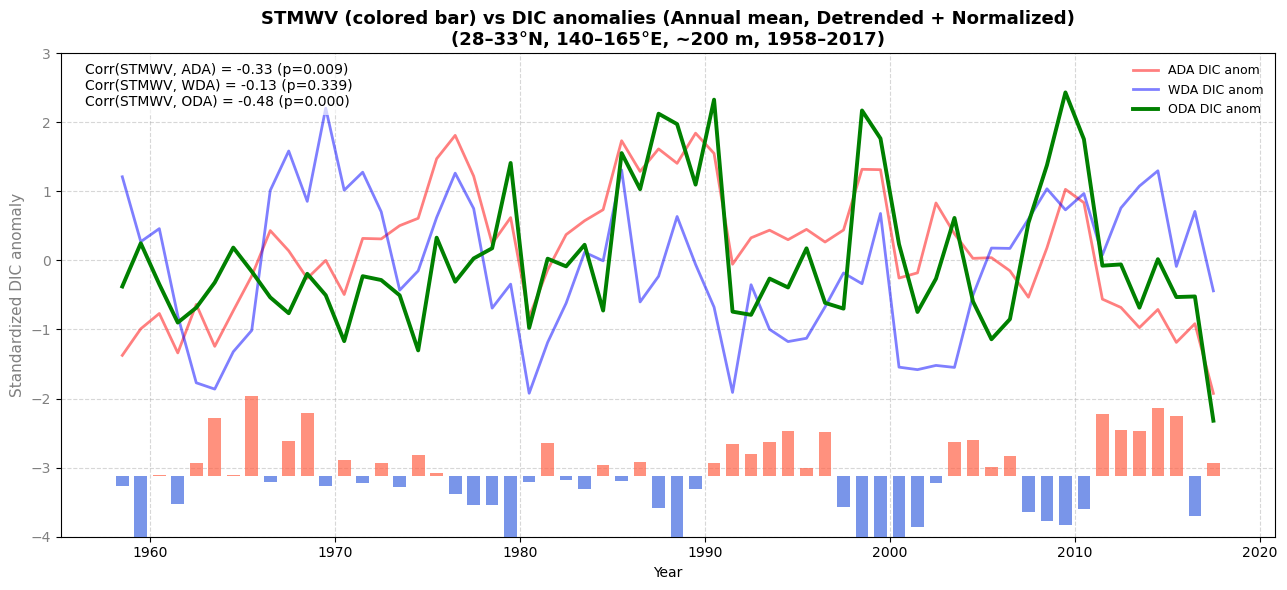

In [147]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# ==========================================================
# 1) Load dataset
# ==========================================================
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")

# ==========================================================
# 2) Convert to annual mean (1958–2017)
# ==========================================================
da_stmwv = (
    STMWV["PD7_STMWV"]
    .sel(time=slice("1958-01", "2017-12"))
    .groupby("time.year").mean("time")
)

# ==========================================================
# 3) Detrend + normalize
# ==========================================================
def detrend_normalize(da):
    years = da.year.values
    times = pd.to_datetime([f"{int(y)}-07-01" for y in years])
    df = pd.Series(da.values, index=times)
    x = np.arange(len(df))
    slope, intercept, *_ = linregress(x, df.values)
    detrended = df - (slope * x + intercept)
    normed = (detrended - detrended.mean()) / detrended.std()
    return normed, df.index

anom_stmwv, t_stmwv = detrend_normalize(da_stmwv)

# ==========================================================
# 4) Extract regional DIC (annual mean)
# ==========================================================
def convert_cftime_to_datetime(da):
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da

def extract_dic_regmean(ds_dic, lat_rng=(28,33), lon_rng=(140,165), depth_pt=-200):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic.sel(lat=slice(*lat_rng), lon=slice(*lon_rng))
              .sel(z_t=depth_pt, method="nearest")
              .mean(dim=["lat", "lon"])
    )
    return convert_cftime_to_datetime(da)

def detrend_normalize_annual(da):
    df = pd.Series(da.values, index=pd.to_datetime(da.time.values))
    annual = df.groupby(df.index.year).mean()
    years = np.array(list(annual.index))
    x = np.arange(len(annual))
    slope, intercept, *_ = linregress(x, annual.values)
    detrended = annual - (slope * x + intercept)
    normed = (detrended - detrended.mean()) / detrended.std()
    return normed, pd.to_datetime([f"{int(y)}-07-01" for y in years])

ts_ADA_raw = extract_dic_regmean(cfg_var_DIC.ADA_ds_rgd)
ts_WDA_raw = extract_dic_regmean(cfg_var_DIC.WDA_ds_rgd)
ts_ODA_raw = extract_dic_regmean(cfg_var_DIC.ODA_ds_rgd)

ts_ADA, time_dic = detrend_normalize_annual(ts_ADA_raw)
ts_WDA, _  = detrend_normalize_annual(ts_WDA_raw)
ts_ODA, _  = detrend_normalize_annual(ts_ODA_raw)

mask = (time_dic >= np.datetime64("1958-01")) & (time_dic <= np.datetime64("2017-12"))
time_dic = time_dic[mask]
ts_ADA = ts_ADA[mask]
ts_WDA = ts_WDA[mask]
ts_ODA = ts_ODA[mask]

# ==========================================================
# 5) Correlations
# ==========================================================
stmwv_arr = anom_stmwv.values

r_ADA, p_ADA = pearsonr(ts_ADA.values, stmwv_arr)
r_WDA, p_WDA = pearsonr(ts_WDA.values, stmwv_arr)
r_ODA, p_ODA = pearsonr(ts_ODA.values, stmwv_arr)



# ==========================================================
# 6) Plot
# ==========================================================
fig, ax1 = plt.subplots(figsize=(13,6))

# --- DIC lines ---
ax1.plot(time_dic, ts_ADA, color="r", alpha=0.5, lw=2, label="ADA DIC anom")
ax1.plot(time_dic, ts_WDA, color="b", alpha=0.5, lw=2, label="WDA DIC anom")
ax1.plot(time_dic, ts_ODA, color="g", lw=2.8, label="ODA DIC anom")

ax1.set_ylim(-4, 3)
ax1.set_ylabel("Standardized DIC anomaly", color="gray", fontsize=11)
ax1.tick_params(axis='y', labelcolor='gray')

# --- STMWV colored bar ---
ax2 = ax1.twinx()
colors = np.where(anom_stmwv > 0, "tomato",
          np.where(anom_stmwv < 0, "royalblue", "lightgray"))
bar_bottom = -7.0
ax2.bar(t_stmwv, anom_stmwv, bottom=bar_bottom, width=250,
        color=colors, alpha=0.7, edgecolor="none")
ax2.set_ylim(bar_bottom - 1.5, bar_bottom + 10.5)
ax2.axis("off")

# legend
ax1.legend(loc="upper right", frameon=False, fontsize=9)

# correlation textbox

# --- formatting helper (bold only if p < 0.05) ---
def fmt_corr(r, p):
    if p < 0.05:
        return f"{r:.2f} (p={p:.3f})"
    else:
        return f"{r:.2f} (p={p:.3f})"

txt = (
    f"Corr(STMWV, ADA) = {fmt_corr(r_ADA, p_ADA)}\n"
    f"Corr(STMWV, WDA) = {fmt_corr(r_WDA, p_WDA)}\n"
    f"Corr(STMWV, ODA) = {fmt_corr(r_ODA, p_ODA)}"
)

ax1.text(
    0.02, 0.98, txt,
    transform=ax1.transAxes,
    va="top", ha="left",
    fontsize=10,
    color="black",
    bbox=dict(facecolor="white", alpha=0.65, edgecolor="none")
)

# style
ax1.set_title(
    "STMWV (colored bar) vs DIC anomalies (Annual mean, Detrended + Normalized)\n"
    "(28–33°N, 140–165°E, ~200 m, 1958–2017)",
    fontsize=13, fontweight="bold"
)
ax1.set_xlabel("Year")
ax1.grid(True, ls="--", alpha=0.5)

plt.tight_layout()
plt.show()


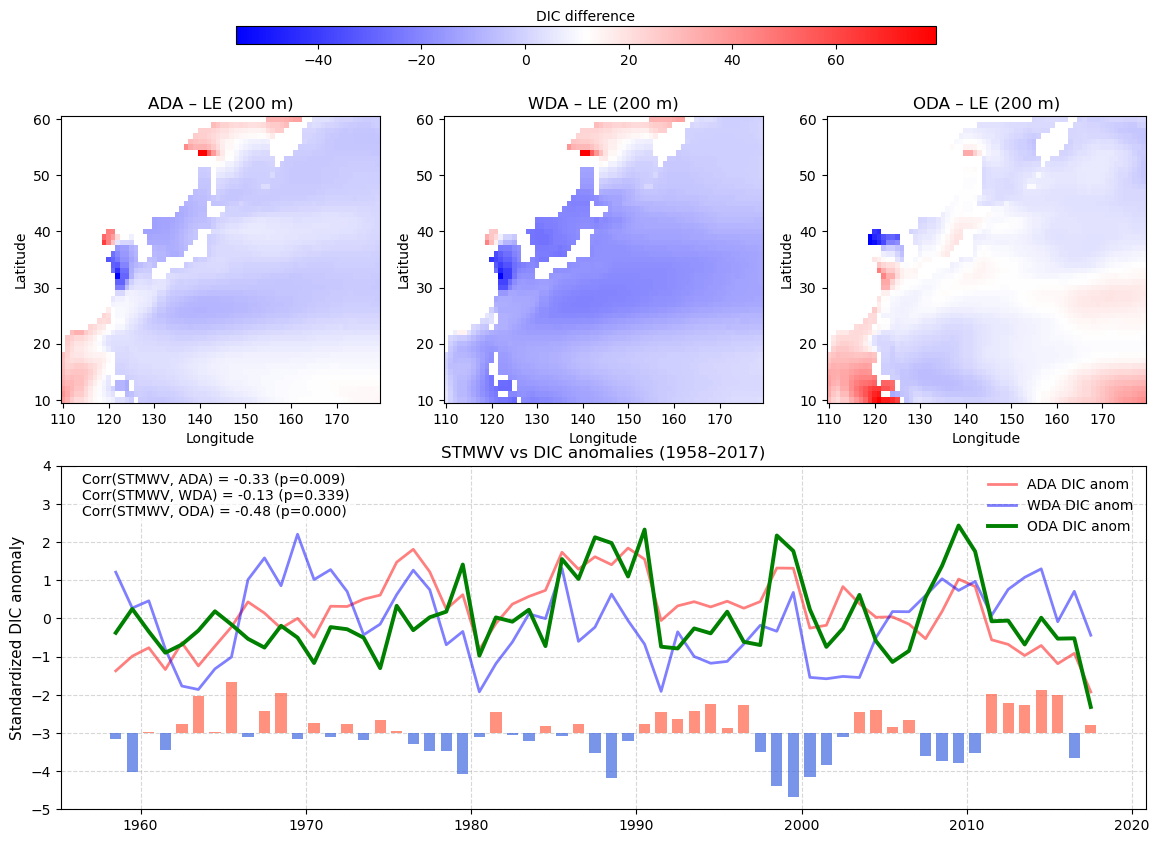

In [174]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# ==========================================================
# 1) Load dataset
# ==========================================================
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")

# ==========================================================
# 2) Convert to annual mean (1958–2017)
# ==========================================================
da_stmwv = (
    STMWV["PD7_STMWV"]
    .sel(time=slice("1958-01", "2017-12"))
    .groupby("time.year").mean("time")
)

# ==========================================================
# 3) Detrend + normalize
# ==========================================================
def detrend_normalize(da):
    years = da.year.values
    times = pd.to_datetime([f"{int(y)}-07-01" for y in years])
    df = pd.Series(da.values, index=times)
    x = np.arange(len(df))
    slope, intercept, *_ = linregress(x, df.values)
    detrended = df - (slope * x + intercept)
    normed = (detrended - detrended.mean()) / detrended.std()
    return normed, df.index

anom_stmwv, t_stmwv = detrend_normalize(da_stmwv)

# ==========================================================
# 4) Extract regional DIC (annual mean)
# ==========================================================
def convert_cftime_to_datetime(da):
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da

def extract_dic_regmean(ds_dic, lat_rng=(28,33), lon_rng=(140,165), depth_pt=-200):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic.sel(lat=slice(*lat_rng), lon=slice(*lon_rng))
              .sel(z_t=depth_pt, method="nearest")
              .mean(dim=["lat", "lon"])
    )
    return convert_cftime_to_datetime(da)

def detrend_normalize_annual(da):
    df = pd.Series(da.values, index=pd.to_datetime(da.time.values))
    annual = df.groupby(df.index.year).mean()
    years = np.array(list(annual.index))
    x = np.arange(len(annual))
    slope, intercept, *_ = linregress(x, annual.values)
    detrended = annual - (slope * x + intercept)
    normed = (detrended - detrended.mean()) / detrended.std()
    return normed, pd.to_datetime([f"{int(y)}-07-01" for y in years])

ts_ADA_raw = extract_dic_regmean(cfg_var_DIC.ADA_ds_rgd)
ts_WDA_raw = extract_dic_regmean(cfg_var_DIC.WDA_ds_rgd)
ts_ODA_raw = extract_dic_regmean(cfg_var_DIC.ODA_ds_rgd)

ts_ADA, time_dic = detrend_normalize_annual(ts_ADA_raw)
ts_WDA, _  = detrend_normalize_annual(ts_WDA_raw)
ts_ODA, _  = detrend_normalize_annual(ts_ODA_raw)

mask = (time_dic >= np.datetime64("1958-01")) & (time_dic <= np.datetime64("2017-12"))
time_dic = time_dic[mask]
ts_ADA = ts_ADA[mask]
ts_WDA = ts_WDA[mask]
ts_ODA = ts_ODA[mask]

# ==========================================================
# 5) Correlations
# ==========================================================
stmwv_arr = anom_stmwv.values

r_ADA, p_ADA = pearsonr(ts_ADA.values, stmwv_arr)
r_WDA, p_WDA = pearsonr(ts_WDA.values, stmwv_arr)
r_ODA, p_ODA = pearsonr(ts_ODA.values, stmwv_arr)

# # 문자열 bold는 쓰지 않고, 숫자 부분을 bold font로 따로 그릴 것
# def draw_corr_line(ax, y, name, r, p):
#     ax.text(0.02, y, f"Corr(STMWV, {name}) = ",
#             transform=ax.transAxes, ha="left", va="top",
#             fontsize=10, color="black")

#     # bold only if significant
#     fontw = "bold" if p < 0.05 else "normal"
#     ax.text(0.40, y, f"{r:.2f}",
#             transform=ax.transAxes,
#             ha="left", va="top",
#             fontsize=10, color="black", fontweight=fontw)

#     ax.text(0.55, y, f"(p={p:.3f})",
#             transform=ax.transAxes, ha="left", va="top",
#             fontsize=10, color="black")


# ==========================================================
# 6) Horizontal maps (ADA–LE, WDA–LE, ODA–LE)
# ==========================================================
# LE 데이터를 불러온다고 가정
# LE_ds = xr.open_dataset("/proj/kimyy/LE/LE_DIC_ensemble_mean.nc")

# 200 m slice
ADA_map = cfg_var_DIC.ADA_ds_rgd.sel(z_t=-200, method="nearest")
WDA_map = cfg_var_DIC.WDA_ds_rgd.sel(z_t=-200, method="nearest")
ODA_map = cfg_var_DIC.ODA_ds_rgd.sel(z_t=-200, method="nearest")
LE_map  = cfg_var_DIC.LE_ds_rgd.sel(z_t=-200, method="nearest")

map_ADA = (ADA_map - LE_map).mean("time")
map_WDA = (WDA_map - LE_map).mean("time")
map_ODA = (ODA_map - LE_map).mean("time")

# ==========================================================
# 7) Create 2×3 panel figure
# ==========================================================
fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 1.2])  # top: maps, bottom: ts

# ---------- 1행: horizontal maps ----------
axm1 = fig.add_subplot(gs[0, 0])
m1 = axm1.pcolormesh(map_ADA.lon, map_ADA.lat, map_ADA, cmap="bwr")
axm1.set_title("ADA – LE (200 m)")

axm2 = fig.add_subplot(gs[0, 1])
m2 = axm2.pcolormesh(map_WDA.lon, map_WDA.lat, map_WDA, cmap="bwr")
axm2.set_title("WDA – LE (200 m)")

axm3 = fig.add_subplot(gs[0, 2])
m3 = axm3.pcolormesh(map_ODA.lon, map_ODA.lat, map_ODA, cmap="bwr")
axm3.set_title("ODA – LE (200 m)")

for ax in [axm1, axm2, axm3]:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# ---------- colorbar at top ----------
cax = fig.add_axes([0.25, 0.96, 0.50, 0.02])  # left, bottom, width, height
cbar = fig.colorbar(m1, cax=cax, orientation="horizontal")

# title above colorbar
cbar.ax.set_title("DIC difference", fontsize=10, pad=4)

# ---------- 2행: timeseries ----------
ax1 = fig.add_subplot(gs[1, :])

# timeseries
ax1.plot(time_dic, ts_ADA, color="r", alpha=0.5, lw=2, label="ADA DIC anom")
ax1.plot(time_dic, ts_WDA, color="b", alpha=0.5, lw=2, label="WDA DIC anom")
ax1.plot(time_dic, ts_ODA, color="g", lw=2.8, label="ODA DIC anom")

ax1.set_ylim(-5, 4)
ax1.set_ylabel("Standardized DIC anomaly", fontsize=11)
ax1.grid(True, ls="--", alpha=0.5)
ax1.legend(loc="upper right", frameon=False)

# # correlation box background
# ax1.text(0.01, 0.99, "", transform=ax1.transAxes,
#          bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

# --- formatting helper (bold only if p < 0.05) ---
def fmt_corr(r, p):
    if p < 0.05:
        return f"{r:.2f} (p={p:.3f})"
    else:
        return f"{r:.2f} (p={p:.3f})"

txt = (
    f"Corr(STMWV, ADA) = {fmt_corr(r_ADA, p_ADA)}\n"
    f"Corr(STMWV, WDA) = {fmt_corr(r_WDA, p_WDA)}\n"
    f"Corr(STMWV, ODA) = {fmt_corr(r_ODA, p_ODA)}"
)

ax1.text(
    0.02, 0.98, txt,
    transform=ax1.transAxes,
    va="top", ha="left",
    fontsize=10,
    color="black",
    bbox=dict(facecolor="white", alpha=0.65, edgecolor="none")
)

ax2 = ax1.twinx()
colors = np.where(anom_stmwv > 0, "tomato",
          np.where(anom_stmwv < 0, "royalblue", "lightgray"))
bar_bottom = -7.0
ax2.bar(t_stmwv, anom_stmwv, bottom=bar_bottom, width=250,
        color=colors, alpha=0.7, edgecolor="none")
ax2.set_ylim(bar_bottom - 3, bar_bottom + 10.5)
ax2.axis("off")

# # ==========================================================
# # Highlight periods where STMWV < -1  (correct year-span shading)
# # ==========================================================

# threshold = -1
# mask_low = anom_stmwv.values < threshold

# # time array는 'YYYY-07-01' 형태이므로 연도만 추출
# years = np.array([t.year for t in t_stmwv])

# starts = []
# ends = []
# in_block = False

# for i in range(len(mask_low)):
#     if mask_low[i] and not in_block:
#         in_block = True
#         starts.append(years[i])
#     elif not mask_low[i] and in_block:
#         in_block = False
#         ends.append(years[i])

# if in_block:
#     ends.append(years[-1])

# # --- draw shading per full-year span ---
# for s, e in zip(starts, ends):
#     ax1.axvspan(
#         pd.to_datetime(f"{s-1}-12-31"),
#         pd.to_datetime(f"{e}-01-31"),
#         color="yellow", alpha=0.25, zorder=0
#     )


ax1.set_title("STMWV vs DIC anomalies (1958–2017)")

# plt.tight_layout()
plt.show()


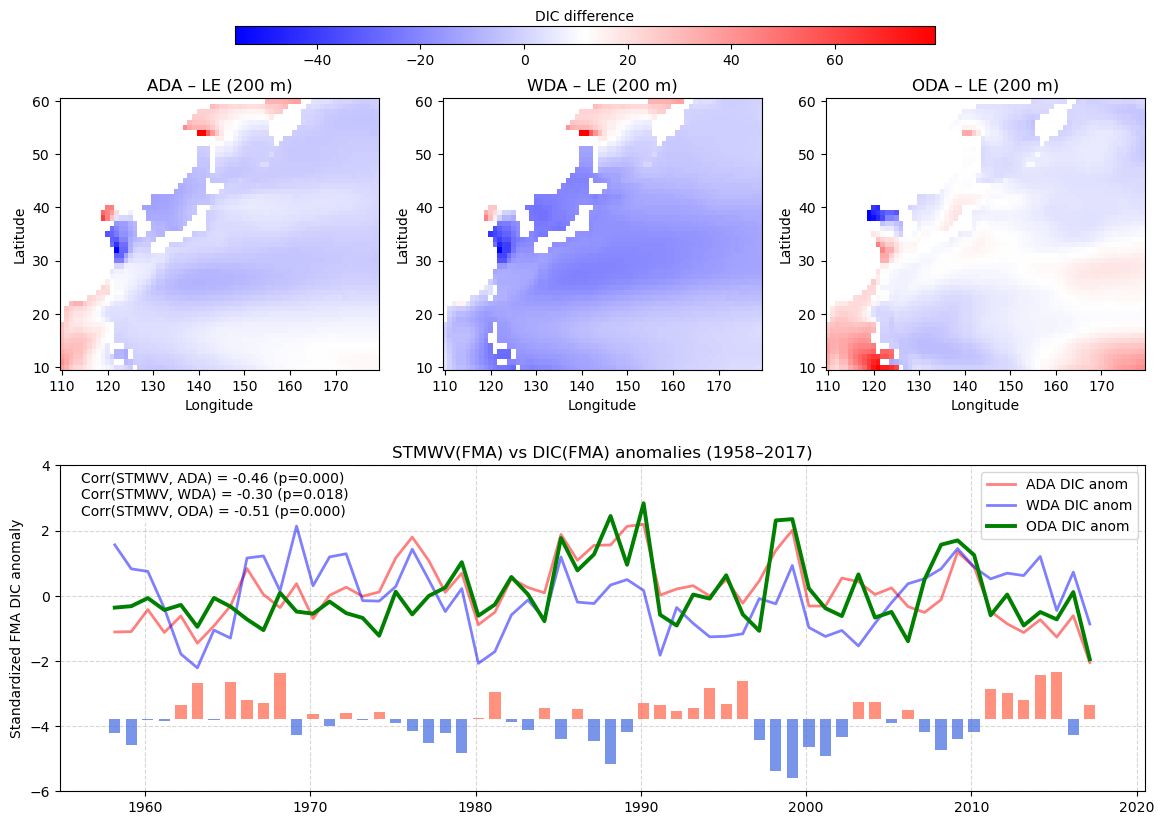

===== Full-period correlation (1958–2017) =====
ADA: r=-0.46, p=0.000
WDA: r=-0.30, p=0.018
ODA: r=-0.51, p=0.000

===== Post-1982 correlation (1982–2017) =====
ADA: r=-0.53, p=0.001
WDA: r=-0.24, p=0.159
ODA: r=-0.56, p=0.000


In [181]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# ==========================================================
# 1) Load dataset
# ==========================================================
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")

# ==========================================================
# 2) Convert to FMA mean (1958–2017)
# ==========================================================
da_stmwv = (
    STMWV["PD7_STMWV"]
    .sel(time=slice("1958-01", "2017-12"))
    .where(STMWV["PD7_STMWV"].time.dt.month.isin([2,3,4]))
    .groupby("time.year").mean("time")
)

# ==========================================================
# 3) Detrend + normalize
# ==========================================================
def detrend_normalize(da):
    years = da.year.values
    times = pd.to_datetime([f"{int(y)}-03-01" for y in years])  # FMA 중심을 3월로
    df = pd.Series(da.values, index=times)
    x = np.arange(len(df))
    slope, intercept, *_ = linregress(x, df.values)
    detrended = df - (slope * x + intercept)
    normed = (detrended - detrended.mean()) / detrended.std()
    return normed, df.index

anom_stmwv, t_stmwv = detrend_normalize(da_stmwv)

# ==========================================================
# 4) Extract DIC FMA regional mean
# ==========================================================
def convert_cftime_to_datetime(da):
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da

def extract_dic_regmean_FMA(ds_dic, lat_rng=(28,33), lon_rng=(140,165), depth_pt=-200):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic.sel(lat=slice(*lat_rng), lon=slice(*lon_rng))
              .sel(z_t=depth_pt, method="nearest")
              .where(ds_dic.time.dt.month.isin([2,3,4]))       # FMA만
              .mean(dim=["lat", "lon"])
    )
    return convert_cftime_to_datetime(da)

def detrend_normalize_FMA(da):
    df = pd.Series(da.values, index=pd.to_datetime(da.time.values))
    fma = df.groupby(df.index.year).mean()                    # FMA mean per year
    years = np.array(list(fma.index))
    x = np.arange(len(fma))
    slope, intercept, *_ = linregress(x, fma.values)
    detrended = fma - (slope * x + intercept)
    normed = (detrended - detrended.mean()) / detrended.std()
    # FMA 중심을 3월 1일로 지정
    return normed, pd.to_datetime([f"{int(y)}-03-01" for y in years])

ts_ADA_raw = extract_dic_regmean_FMA(cfg_var_DIC.ADA_ds_rgd)
ts_WDA_raw = extract_dic_regmean_FMA(cfg_var_DIC.WDA_ds_rgd)
ts_ODA_raw = extract_dic_regmean_FMA(cfg_var_DIC.ODA_ds_rgd)

ts_ADA, time_dic = detrend_normalize_FMA(ts_ADA_raw)
ts_WDA, _        = detrend_normalize_FMA(ts_WDA_raw)
ts_ODA, _        = detrend_normalize_FMA(ts_ODA_raw)

mask = (time_dic >= np.datetime64("1958-01")) & (time_dic <= np.datetime64("2017-12"))
time_dic = time_dic[mask]
ts_ADA = ts_ADA[mask]
ts_WDA = ts_WDA[mask]
ts_ODA = ts_ODA[mask]

# ==========================================================
# 5) Correlations
# ==========================================================
stmwv_arr = anom_stmwv.values

r_ADA, p_ADA = pearsonr(ts_ADA.values, stmwv_arr)
r_WDA, p_WDA = pearsonr(ts_WDA.values, stmwv_arr)
r_ODA, p_ODA = pearsonr(ts_ODA.values, stmwv_arr)

# correlation text formatter
def fmt_corr(r, p):
    return f"{r:.2f} (p={p:.3f})"

txt = (
    f"Corr(STMWV, ADA) = {fmt_corr(r_ADA, p_ADA)}\n"
    f"Corr(STMWV, WDA) = {fmt_corr(r_WDA, p_WDA)}\n"
    f"Corr(STMWV, ODA) = {fmt_corr(r_ODA, p_ODA)}"
)

# ==========================================================
# 6) Horizontal maps (time mean, unchanged)
# ==========================================================
ADA_map = cfg_var_DIC.ADA_ds_rgd.sel(z_t=-200, method="nearest")
WDA_map = cfg_var_DIC.WDA_ds_rgd.sel(z_t=-200, method="nearest")
ODA_map = cfg_var_DIC.ODA_ds_rgd.sel(z_t=-200, method="nearest")
LE_map  = cfg_var_DIC.LE_ds_rgd.sel(z_t=-200, method="nearest")

map_ADA = (ADA_map - LE_map).mean("time")
map_WDA = (WDA_map - LE_map).mean("time")
map_ODA = (ODA_map - LE_map).mean("time")

# ==========================================================
# 7) Plot (same layout as before)
# ==========================================================
fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 1.2])

# maps
axm1 = fig.add_subplot(gs[0, 0])
m1 = axm1.pcolormesh(map_ADA.lon, map_ADA.lat, map_ADA, cmap="bwr")
axm1.set_title("ADA – LE (200 m)")

axm2 = fig.add_subplot(gs[0, 1])
m2 = axm2.pcolormesh(map_WDA.lon, map_WDA.lat, map_WDA, cmap="bwr")
axm2.set_title("WDA – LE (200 m)")

axm3 = fig.add_subplot(gs[0, 2])
m3 = axm3.pcolormesh(map_ODA.lon, map_ODA.lat, map_ODA, cmap="bwr")
axm3.set_title("ODA – LE (200 m)")

for ax in [axm1, axm2, axm3]:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

cax = fig.add_axes([0.25, 0.94, 0.50, 0.02])
cbar = fig.colorbar(m1, cax=cax, orientation="horizontal")
cbar.ax.set_title("DIC difference", fontsize=10, pad=4)

# timeseries
ax1 = fig.add_subplot(gs[1, :])
ax1.plot(time_dic, ts_ADA, "r", alpha=0.5, lw=2, label="ADA DIC anom")
ax1.plot(time_dic, ts_WDA, "b", alpha=0.5, lw=2, label="WDA DIC anom")
ax1.plot(time_dic, ts_ODA, "g", lw=2.8, label="ODA DIC anom")
ax1.set_ylabel("Standardized FMA DIC anomaly")
ax1.set_ylim(-6, 4)
ax1.grid(ls="--", alpha=0.5)
ax1.legend()

# STMWV bar
ax2 = ax1.twinx()
colors = np.where(anom_stmwv > 0, "tomato",
          np.where(anom_stmwv < 0, "royalblue", "lightgray"))
bar_bottom = -7.0
ax2.bar(t_stmwv, anom_stmwv, bottom=bar_bottom, width=250,
        color=colors, alpha=0.7, edgecolor="none")
ax2.set_ylim(bar_bottom - 3, bar_bottom + 10.5)
ax2.axis("off")

# correlation label
ax1.text(
    0.02, 0.98, txt,
    transform=ax1.transAxes, va="top", ha="left",
    fontsize=10, color="black",
    bbox=dict(facecolor="white", alpha=0.65, edgecolor="none")
)

ax1.set_title("STMWV(FMA) vs DIC(FMA) anomalies (1958–2017)")

plt.subplots_adjust(hspace=0.32)
plt.show()

# ----------------------------
# 1982–2017 구간 마스크
# ----------------------------
mask_82 = (time_dic >= np.datetime64("1982-01")) & (time_dic <= np.datetime64("2017-12"))

# ----------------------------
# 후기 기간 correlation
# ----------------------------
r_ADA_82, p_ADA_82 = pearsonr(ts_ADA[mask_82].values, anom_stmwv[mask_82].values)
r_WDA_82, p_WDA_82 = pearsonr(ts_WDA[mask_82].values, anom_stmwv[mask_82].values)
r_ODA_82, p_ODA_82 = pearsonr(ts_ODA[mask_82].values, anom_stmwv[mask_82].values)

# ----------------------------
# print summary
# ----------------------------
print("===== Full-period correlation (1958–2017) =====")
print(f"ADA: r={r_ADA:.2f}, p={p_ADA:.3f}")
print(f"WDA: r={r_WDA:.2f}, p={p_WDA:.3f}")
print(f"ODA: r={r_ODA:.2f}, p={p_ODA:.3f}")

print("\n===== Post-1982 correlation (1982–2017) =====")
print(f"ADA: r={r_ADA_82:.2f}, p={p_ADA_82:.3f}")
print(f"WDA: r={r_WDA_82:.2f}, p={p_WDA_82:.3f}")
print(f"ODA: r={r_ODA_82:.2f}, p={p_ODA_82:.3f}")


In [186]:
import xarray as xr
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ==========================================================
# 1) Function: compute 2000 µmol kg⁻¹ isosurface depth (D2000)
# ==========================================================
def compute_D2000(ds_DIC, target_dic=2000.0, zmax_cm=40000, dz_cm=100):
    """
    Compute the depth where DIC = 2000 µmol kg⁻¹ (D2000).
    Positive depth = downward from surface.

    Parameters
    ----------
    ds_DIC : xarray.DataArray
        4D DIC field (time, z_t, lat, lon)
    target_dic : float
        Target isosurface value [µmol kg⁻¹]
    zmax_cm : int
        Maximum depth for interpolation [cm]
    dz_cm : int
        Interpolation step [cm]

    Returns
    -------
    D2000 : xarray.DataArray
        Depth (m) of 2000 µmol kg⁻¹ isosurface at each grid cell
    """
    DIC = ds_DIC
    z_t = DIC["z_t"]
    z_new = np.arange(1000, zmax_cm + dz_cm, dz_cm)

    # ---------------------------------------------
    # Inner function: find 2000 µmol kg⁻¹ crossing
    # ---------------------------------------------
    def find_D2000(DIC_profile, z_profile):
        valid = np.isfinite(DIC_profile)
        if valid.sum() < 2:
            return np.nan

        f = interp1d(
            z_profile[valid], DIC_profile[valid],
            kind="linear", bounds_error=False, fill_value=np.nan
        )
        DIC_interp = f(z_new)
        diff = DIC_interp - target_dic
        sign_change = np.where(np.diff(np.sign(diff)) != 0)[0]
        if len(sign_change) == 0:
            return np.nan

        i = sign_change[0]
        z1, z2 = z_new[i], z_new[i + 1]
        D1, D2 = DIC_interp[i], DIC_interp[i + 1]
        D2000_cm = z1 + (target_dic - D1) * (z2 - z1) / (D2 - D1)
        return D2000_cm / 100.0  # convert cm → m

    # Apply along vertical dimension
    D2000 = xr.apply_ufunc(
        find_D2000,
        DIC,
        z_t,
        input_core_dims=[["z_t"], ["z_t"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    )

    D2000.name = "D2000"
    D2000.attrs["long_name"] = "Depth of 2000 µmol kg⁻¹ DIC isosurface"
    D2000.attrs["units"] = "m"
    return D2000


# ==========================================================
# 2) Apply to each experiment
# ==========================================================
D2000_LE  = compute_D2000(cfg_var_DIC.LE_ds_rgd)
D2000_ADA = compute_D2000(cfg_var_DIC.ADA_ds_rgd)
D2000_WDA = compute_D2000(cfg_var_DIC.WDA_ds_rgd)
D2000_ODA = compute_D2000(cfg_var_DIC.ODA_ds_rgd)

# ==========================================================
# 3) Compute long-term mean (1955–2020)
# ==========================================================
def get_longterm_mean(ds, start_year=1958, end_year=2017):
    """Return time mean over given year range."""
    return ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean("time")

D2000_LE_mean  = get_longterm_mean(D2000_LE)
D2000_ADA_mean = get_longterm_mean(D2000_ADA)
D2000_WDA_mean = get_longterm_mean(D2000_WDA)
D2000_ODA_mean = get_longterm_mean(D2000_ODA)

# Compute anomalies (Exp − LE)
D2000_ADA_anom = D2000_ADA_mean - D2000_LE_mean
D2000_WDA_anom = D2000_WDA_mean - D2000_LE_mean
D2000_ODA_anom = D2000_ODA_mean - D2000_LE_mean


In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# ==========================================================
# 1) Load dataset
# ==========================================================
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")

# ==========================================================
# 2) Convert to FMA mean (1958–2017)
# ==========================================================
da_stmwv = (
    STMWV["PD7_STMWV"]
    .sel(time=slice("1958-01", "2017-12"))
    .where(STMWV["PD7_STMWV"].time.dt.month.isin([2,3,4]))
    .groupby("time.year").mean("time")
)

# ==========================================================
# 3) Detrend + normalize (FMA)
# ==========================================================
def detrend_normalize(da):
    years = da.year.values
    times = pd.to_datetime([f"{int(y)}-03-01" for y in years])  # FMA 중심 3월
    df = pd.Series(da.values, index=times)
    x = np.arange(len(df))
    slope, intercept, *_ = linregress(x, df.values)
    detrended = df - (slope * x + intercept)
    normed = (detrended - detrended.mean()) / detrended.std()
    return normed, df.index

anom_stmwv, t_stmwv = detrend_normalize(da_stmwv)

# ==========================================================
# 4) Extract regional DIC FMA mean
# ==========================================================
def convert_cftime_to_datetime(da):
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da

def extract_dic_regmean_FMA(ds_dic, lat_rng=(28,33), lon_rng=(140,165), depth_pt=-200):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic.sel(lat=slice(*lat_rng), lon=slice(*lon_rng))
              .sel(z_t=depth_pt, method="nearest")
              .where(ds_dic.time.dt.month.isin([2,3,4]))
              .mean(dim=["lat", "lon"])
    )
    return convert_cftime_to_datetime(da)

def detrend_normalize_FMA(da):
    df = pd.Series(da.values, index=pd.to_datetime(da.time.values))
    fma = df.groupby(df.index.year).mean()
    years = np.array(list(fma.index))
    x = np.arange(len(fma))
    slope, intercept, *_ = linregress(x, fma.values)
    detrended = fma - (slope * x + intercept)
    normed = (detrended - detrended.mean()) / detrended.std()
    return normed, pd.to_datetime([f"{int(y)}-03-01" for y in years])

ts_ADA_raw = extract_dic_regmean_FMA(cfg_var_DIC.ADA_ds_rgd)
ts_WDA_raw = extract_dic_regmean_FMA(cfg_var_DIC.WDA_ds_rgd)
ts_ODA_raw = extract_dic_regmean_FMA(cfg_var_DIC.ODA_ds_rgd)

ts_ADA, time_dic = detrend_normalize_FMA(ts_ADA_raw)
ts_WDA, _        = detrend_normalize_FMA(ts_WDA_raw)
ts_ODA, _        = detrend_normalize_FMA(ts_ODA_raw)

mask = (time_dic >= np.datetime64("1958-01")) & (time_dic <= np.datetime64("2017-12"))
time_dic = time_dic[mask]
ts_ADA = ts_ADA[mask]
ts_WDA = ts_WDA[mask]
ts_ODA = ts_ODA[mask]

# ==========================================================
# 5) Correlations
# ==========================================================
stmwv_arr = anom_stmwv.values
r_ADA, p_ADA = pearsonr(ts_ADA.values, stmwv_arr)
r_WDA, p_WDA = pearsonr(ts_WDA.values, stmwv_arr)
r_ODA, p_ODA = pearsonr(ts_ODA.values, stmwv_arr)

def fmt_corr(r, p):
    return f"{r:.2f} (p={p:.3f})"

txt = (
    f"Corr(STMWV, ADA) = {fmt_corr(r_ADA, p_ADA)}\n"
    f"Corr(STMWV, WDA) = {fmt_corr(r_WDA, p_WDA)}\n"
    f"Corr(STMWV, ODA) = {fmt_corr(r_ODA, p_ODA)}"
)

# ==========================================================
# 6) Row 1: Use precomputed D2000 anomalies
# ==========================================================
map_ADA = D2000_ADA_anom
map_WDA = D2000_WDA_anom
map_ODA = D2000_ODA_anom

# ==========================================================
# 7) Plot panel
# ==========================================================
fig = plt.figure(figsize=(14, 9))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 1.2])

# ---------------- Row 1 maps ----------------
axm1 = fig.add_subplot(gs[0, 0])
m1 = axm1.pcolormesh(map_ADA.lon, map_ADA.lat, map_ADA,
                     cmap="bwr", vmin=-30, vmax=30)
axm1.set_title("ADA – LE (depth where DIC = 2000)")

axm2 = fig.add_subplot(gs[0, 1])
m2 = axm2.pcolormesh(map_WDA.lon, map_WDA.lat, map_WDA,
                     cmap="bwr", vmin=-30, vmax=30)
axm2.set_title("WDA – LE (depth where DIC = 2000)")

axm3 = fig.add_subplot(gs[0, 2])
m3 = axm3.pcolormesh(map_ODA.lon, map_ODA.lat, map_ODA,
                     cmap="bwr", vmin=-30, vmax=30)
axm3.set_title("ODA – LE (depth where DIC = 2000)")

for ax in [axm1, axm2, axm3]:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

cbar.ax.set_title("Depth difference (m) where DIC = 2000", fontsize=10, pad=4)



for ax in [axm1, axm2, axm3]:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# colorbar
cax = fig.add_axes([0.25, 0.94, 0.50, 0.02])
cbar = fig.colorbar(m1, cax=cax, orientation="horizontal", extend="both")
cbar.ax.set_title("Depth anomaly (m) where DIC = 2000", fontsize=10, pad=4)

# ---------------- Row 2 timeseries ----------------
ax1 = fig.add_subplot(gs[1, :])
ax1.plot(time_dic, ts_ADA, "r", alpha=0.5, lw=2, label="ADA")
ax1.plot(time_dic, ts_WDA, "b", alpha=0.5, lw=2, label="WDA")
ax1.plot(time_dic, ts_ODA, "g", lw=2.8, label="ODA")
ax1.set_ylabel("Standardized FMA DIC anomaly")
ax1.set_ylim(-6, 4)
ax1.grid(ls="--", alpha=0.5)
ax1.legend()

# STMWV bar
ax2 = ax1.twinx()
colors = np.where(anom_stmwv > 0, "tomato",
          np.where(anom_stmwv < 0, "royalblue", "lightgray"))
bar_bottom = -7.0
ax2.bar(t_stmwv, anom_stmwv, bottom=bar_bottom, width=250,
        color=colors, alpha=0.7, edgecolor="none")
ax2.set_ylim(bar_bottom - 3, bar_bottom + 10.5)
ax2.axis("off")

# correlation box
ax1.text(
    0.02, 0.98, txt,
    transform=ax1.transAxes, va="top", ha="left",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.65, edgecolor="none")
)

ax1.set_title("STMWV(FMA) vs DIC(FMA) anomalies (1958–2017)")
plt.subplots_adjust(hspace=0.32)
plt.show()


In [142]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# ==========================================================
# 1) Load dataset
# ==========================================================
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")

# ==========================================================
# 2) Convert to annual mean (1958–2017)
# ==========================================================
da_stmwv = (
    STMWV["PD7_STMWV"]
    .sel(time=slice("1958-01", "2017-12"))
    .groupby("time.year").mean("time")
)

# ==========================================================
# 3) Detrend + normalize
# ==========================================================
def detrend_normalize(da):
    years = da.year.values
    times = pd.to_datetime([f"{int(y)}-07-01" for y in years])
    df = pd.Series(da.values, index=times)
    x = np.arange(len(df))
    slope, intercept, *_ = linregress(x, df.values)
    detrended = df - (slope * x + intercept)
    normed = (detrended - detrended.mean()) / detrended.std()
    return normed, df.index

anom_stmwv, t_stmwv = detrend_normalize(da_stmwv)

# ==========================================================
# 4) Extract regional DIC (annual mean)
# ==========================================================
def convert_cftime_to_datetime(da):
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da

def extract_dic_regmean(ds_dic, lat_rng=(28,33), lon_rng=(140,165), depth_pt=-200):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic.sel(lat=slice(*lat_rng), lon=slice(*lon_rng))
              .sel(z_t=depth_pt, method="nearest")
              .mean(dim=["lat", "lon"])
    )
    return convert_cftime_to_datetime(da)

def detrend_normalize_annual(da):
    df = pd.Series(da.values, index=pd.to_datetime(da.time.values))
    annual = df.groupby(df.index.year).mean()
    years = np.array(list(annual.index))
    x = np.arange(len(annual))
    slope, intercept, *_ = linregress(x, annual.values)
    detrended = annual - (slope * x + intercept)
    normed = (detrended - detrended.mean()) / detrended.std()
    return normed, pd.to_datetime([f"{int(y)}-07-01" for y in years])

ts_ADA_raw = extract_dic_regmean(cfg_var_DIC.ADA_ds_rgd)
ts_WDA_raw = extract_dic_regmean(cfg_var_DIC.WDA_ds_rgd)
ts_ODA_raw = extract_dic_regmean(cfg_var_DIC.ODA_ds_rgd)

ts_ADA, time_dic = detrend_normalize_annual(ts_ADA_raw)
ts_WDA, _ = detrend_normalize_annual(ts_WDA_raw)
ts_ODA, _ = detrend_normalize_annual(ts_ODA_raw)

mask = (time_dic >= np.datetime64("1958-01")) & (time_dic <= np.datetime64("2017-12"))
time_dic = time_dic[mask]
ts_ADA = ts_ADA[mask]
ts_WDA = ts_WDA[mask]
ts_ODA = ts_ODA[mask]

# ==========================================================
# 5) Correlation computation (robust)
# ==========================================================
def corr_with_stmwv(ts_dic, stmwv):
    # Ensure both are pandas.Series with DatetimeIndex
    ts_dic = pd.Series(ts_dic.values, index=pd.to_datetime(ts_dic.index))
    stmwv = pd.Series(stmwv.values, index=pd.to_datetime(stmwv.index))

    # Convert to annual mean using year as index
    ts_dic_year = pd.Series(ts_dic.values, index=ts_dic.index.year)
    stmwv_year = pd.Series(stmwv.values, index=stmwv.index.year)

    # Align by common years
    common_years = np.intersect1d(stmwv_year.index, ts_dic_year.index)
    if len(common_years) == 0:
        return np.nan

    x = stmwv_year.loc[common_years]
    y = ts_dic_year.loc[common_years]

    valid = np.isfinite(x) & np.isfinite(y)
    if valid.sum() < 3:
        return np.nan

    r, _ = pearsonr(x[valid], y[valid])
    return r

r_ADA = corr_with_stmwv(ts_ADA, anom_stmwv)
r_WDA = corr_with_stmwv(ts_WDA, anom_stmwv)
r_ODA = corr_with_stmwv(ts_ODA, anom_stmwv)

# ==========================================================
# 6) Plot (DIC lines + STMWV bar + correlation text)
# ==========================================================
fig, ax1 = plt.subplots(figsize=(13,6))

# --- DIC lines ---
ax1.plot(time_dic, ts_ADA, color="r", alpha=0.5, lw=2, label=f"ADA DIC anom (r={r_ADA:.2f})")
ax1.plot(time_dic, ts_WDA, color="b", alpha=0.5, lw=2, label=f"WDA DIC anom (r={r_WDA:.2f})")
ax1.plot(time_dic, ts_ODA, color="g", lw=2.8, label=f"ODA DIC anom (r={r_ODA:.2f})")

ax1.set_ylim(-4, 3)
ax1.set_ylabel("Standardized DIC anomaly", color="gray", fontsize=11)
ax1.tick_params(axis='y', labelcolor='gray')

# --- STMWV colored bar (positive=red, negative=blue) ---
ax2 = ax1.twinx()
colors = np.where(anom_stmwv > 0, "tomato", "royalblue")
bar_bottom = -6.8
ax2.bar(t_stmwv, np.ones_like(anom_stmwv), bottom=bar_bottom, width=300, 
        color=colors, alpha=0.6, edgecolor="none")
ax2.set_ylim(bar_bottom - 1.0, bar_bottom + 10.0)
ax2.axis("off")

# --- Text annotation ---
text_str = (
    f"Correlation with STMWV (1958–2017)\n"
    f"ADA: {r_ADA:.2f}\n"
    f"WDA: {r_WDA:.2f}\n"
    f"ODA: {r_ODA:.2f}"
)
ax1.text(0.02, 0.95, text_str, transform=ax1.transAxes,
         va="top", ha="left", fontsize=10, color="black",
         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

# --- legend & title ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc="upper right", frameon=False, fontsize=9)

ax1.set_title(
    "STMWV (colored bar) vs DIC anomalies (Annual mean, Detrended + Normalized)\n"
    "(28–33°N, 140–165°E, ~200 m, 1958–2017)",
    fontsize=13, fontweight="bold"
)
ax1.set_xlabel("Year")
ax1.grid(True, ls="--", alpha=0.5)

plt.tight_layout()
plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 60

In [103]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# ==========================================================
# 1) Load datasets
# ==========================================================
AVISO = xr.open_dataset("/proj/kimyy/tr_sysong/AVISO_KE_SSH_1993to2022.nc")["AVISO_KE_SSH"]
REANAL = xr.open_dataset("/proj/kimyy/tr_sysong/REANAL_KE_SSH_1958to2022.nc")["OFES2_KE_SSH"]
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")["PD7_STMWV"]

def convert_cftime_to_datetime(da):
    if np.issubdtype(da.time.dtype, np.datetime64):
        return da
    da = da.copy()
    da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da

def extract_dic_point(ds_dic, lat_pt=31, lon_pt=155, depth_pt=-200):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = ds_dic.sel(lat=lat_pt, lon=lon_pt, method="nearest").sel(z_t=depth_pt, method="nearest")
    return convert_cftime_to_datetime(da)

dic_ADA = extract_dic_point(cfg_var_DIC.ADA_ds_rgd)
dic_WDA = extract_dic_point(cfg_var_DIC.WDA_ds_rgd)
dic_ODA = extract_dic_point(cfg_var_DIC.ODA_ds_rgd)

# ==========================================================
# 2) Helper: deseason + detrend + normalize on given common period
# ==========================================================
def deseason_detrend_normalize_common(da1, da2):
    """Robust: match overlapping months, handle CFTime/datetime differences, skip empty overlaps."""
    # --- 강제 datetime64 변환 ---
    def to_datetime64(da):
        if not np.issubdtype(da.time.dtype, np.datetime64):
            da = da.copy()
            da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
        return da

    da1 = to_datetime64(da1)
    da2 = to_datetime64(da2)

    # --- 월 단위로 반올림 (월말 기준) ---
    da1["time"] = da1.indexes["time"].to_period("M").to_timestamp("M")
    da2["time"] = da2.indexes["time"].to_period("M").to_timestamp("M")

    # --- 실제 교집합 찾기 ---
    common_times = np.intersect1d(da1.time.values, da2.time.values)
    if len(common_times) == 0:
        print(f"⚠️ No overlap between series — skipping ({da1.name} vs {da2.name})")
        return np.array([]), np.array([]), np.array([])

    da1 = da1.sel(time=common_times)
    da2 = da2.sel(time=common_times)
    time = pd.to_datetime(common_times)

    # --- DataFrame 생성 ---
    df = pd.DataFrame({"x": da1.values, "y": da2.values}, index=time)

    # --- 계절성 제거 ---
    if len(df) < 12:
        print(f"⚠️ Too short for seasonal removal ({len(df)} months). Skipping detrend.")
        return df["x"], df["y"], time
    df = df.groupby(df.index.month).transform(lambda x: x - x.mean())

    # --- 선형 추세 제거 ---
    x_idx = np.arange(len(df))
    for col in df.columns:
        slope, intercept, *_ = linregress(x_idx, df[col])
        df[col] -= (slope * x_idx + intercept)

    # --- 정규화 ---
    df = (df - df.mean()) / df.std()

    return df["x"], df["y"], time




# ==========================================================
# 3) Lead–lag correlation function
# ==========================================================
def leadlag_corr(x, y, max_lag=24):
    n = min(len(x), len(y))
    x, y = np.array(x[:n]), np.array(y[:n])
    lags = np.arange(-max_lag, max_lag + 1)
    corr = np.full_like(lags, np.nan, dtype=float)
    for i, lag in enumerate(lags):
        if lag < 0:
            corr[i] = pearsonr(x[-lag:], y[:len(y)+lag])[0]
        elif lag > 0:
            corr[i] = pearsonr(x[:-lag], y[lag:])[0]
        else:
            corr[i] = pearsonr(x, y)[0]
    return lags, corr

# ==========================================================
# 4) Compute correlations (each index × each DIC)
# ==========================================================
indices = {
    "AVISO": AVISO,
    "OFES2": REANAL,
    "STMWV": STMWV
}
DICs = {
    "ADA": dic_ADA,
    "WDA": dic_WDA,
    "ODA": dic_ODA
}

max_lag = 24
corr_results = {dic: {} for dic in DICs}

for dic_key, dic_data in DICs.items():
    for idx_key, idx_data in indices.items():
        x_idx, y_dic, time_common = deseason_detrend_normalize_common(idx_data, dic_data)
        lags, corr = leadlag_corr(x_idx, y_dic, max_lag=max_lag)
        corr_results[dic_key][idx_key] = (lags, corr)

# ==========================================================
# 5) Plot 3×1 (ADA, WDA, ODA)
# ==========================================================
fig, axes = plt.subplots(3, 1, figsize=(9, 9), sharex=True, sharey=True)
colors = {"AVISO": "C3", "OFES2": "C0", "STMWV": "C2"}

for i, dic_key in enumerate(["ADA", "WDA", "ODA"]):
    ax = axes[i]
    for idx_key, color in colors.items():
        lags, corr = corr_results[dic_key][idx_key]
        ax.plot(lags, corr, lw=2, color=color, label=idx_key)

    ax.axhline(0, color="k", lw=0.8)
    ax.axvline(0, color="k", ls="--", lw=0.8)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlim(-max_lag, max_lag)
    ax.set_title(f"{dic_key} DIC anomaly (matched periods per index)", fontsize=11, fontweight="bold")
    ax.grid(True, ls="--", alpha=0.4)
    if i == 2:
        ax.set_xlabel("Lag (months) → positive = Index leads DIC")
    ax.set_ylabel("r")

axes[0].legend(loc="upper right", frameon=False, fontsize=9)
plt.suptitle("Lead–Lag Correlation (Deseasoned, Detrended per Index Period)\n31°N, 155°E, ~200m", fontsize=12, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


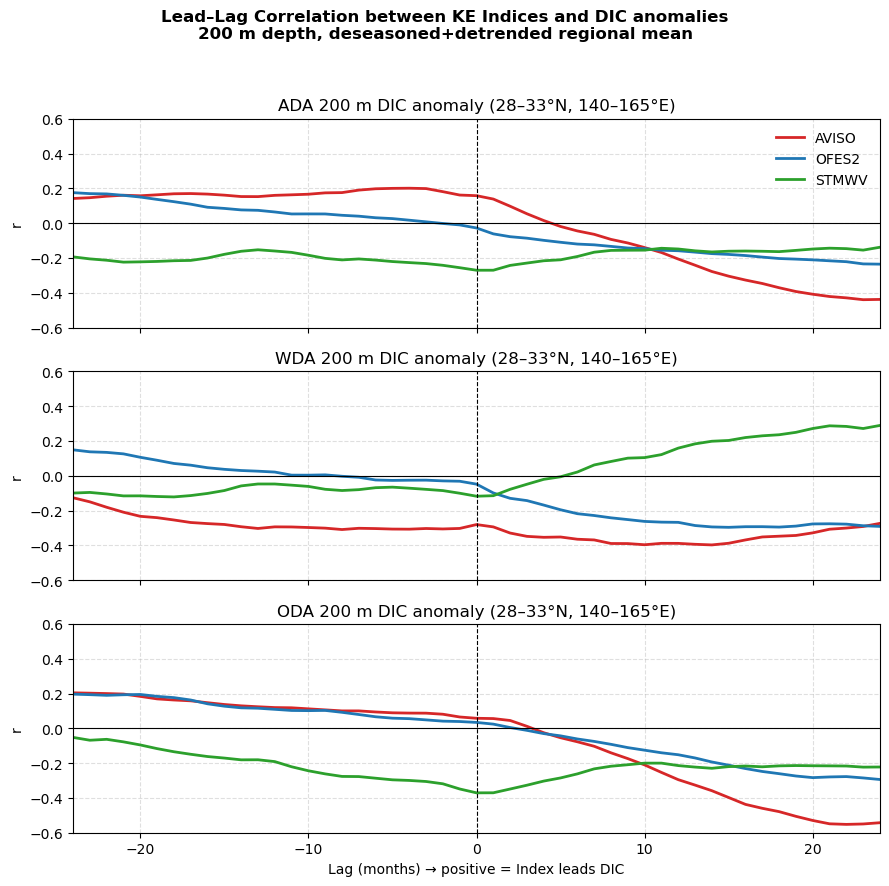

In [113]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# ==========================================================
# 1) Load KE indices
# ==========================================================
AVISO = xr.open_dataset("/proj/kimyy/tr_sysong/AVISO_KE_SSH_1993to2022.nc")["AVISO_KE_SSH"]
REANAL = xr.open_dataset("/proj/kimyy/tr_sysong/REANAL_KE_SSH_1958to2022.nc")["OFES2_KE_SSH"]
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")["PD7_STMWV"]
indices = {"AVISO": AVISO, "OFES2": REANAL, "STMWV": STMWV}

# ==========================================================
# 2) Extract 200 m DIC (28–33 N, 140–165 E)
# ==========================================================
def extract_dic_regionalmean(ds_dic, lat_rng=(28,33), lon_rng=(140,165), depth_pt=-200):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (
        ds_dic.sel(lat=slice(*lat_rng), lon=slice(*lon_rng))
              .sel(z_t=depth_pt, method="nearest")
              .mean(dim=["lat","lon"])
    )
    return da

DICs = {
    "ADA": extract_dic_regionalmean(cfg_var_DIC.ADA_ds_rgd),
    "WDA": extract_dic_regionalmean(cfg_var_DIC.WDA_ds_rgd),
    "ODA": extract_dic_regionalmean(cfg_var_DIC.ODA_ds_rgd),
}

# ==========================================================
# 3) Helper functions
# ==========================================================
def to_datetime64(da):
    if not np.issubdtype(da.time.dtype, np.datetime64):
        da = da.copy()
        da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da

def deseason_detrend_normalize_common(da1, da2):
    da1, da2 = to_datetime64(da1), to_datetime64(da2)
    s1 = pd.Series(da1.values, index=pd.to_datetime(da1.time.values)).groupby(lambda t: (t.year, t.month)).mean()
    s2 = pd.Series(da2.values, index=pd.to_datetime(da2.time.values)).groupby(lambda t: (t.year, t.month)).mean()
    common = s1.index.intersection(s2.index)
    if len(common) < 12:
        return None
    s1, s2 = s1.loc[common], s2.loc[common]
    df = pd.DataFrame({"x": s1.values, "y": s2.values}, index=pd.to_datetime([f"{y}-{m:02d}-15" for y,m in common]))
    df = df.groupby(df.index.month).transform(lambda x: x - x.mean())
    x_idx = np.arange(len(df))
    for c in df.columns:
        s, i, *_ = linregress(x_idx, df[c])
        df[c] -= (s * x_idx + i)
    df = (df - df.mean()) / df.std()
    return df["x"], df["y"]

def leadlag_corr(x, y, max_lag=24):
    n = min(len(x), len(y))
    x, y = np.array(x[:n]), np.array(y[:n])
    lags = np.arange(-max_lag, max_lag+1)
    corr = np.full_like(lags, np.nan, dtype=float)
    for i, lag in enumerate(lags):
        if lag < 0:
            mask = np.isfinite(x[-lag:]) & np.isfinite(y[:len(y)+lag])
            if mask.sum()>3: corr[i] = pearsonr(x[-lag:][mask], y[:len(y)+lag][mask])[0]
        elif lag > 0:
            mask = np.isfinite(x[:-lag]) & np.isfinite(y[lag:])
            if mask.sum()>3: corr[i] = pearsonr(x[:-lag][mask], y[lag:][mask])[0]
        else:
            mask = np.isfinite(x) & np.isfinite(y)
            if mask.sum()>3: corr[i] = pearsonr(x[mask], y[mask])[0]
    return lags, corr

# ==========================================================
# 4) Correlation for each DIC × index
# ==========================================================
max_lag = 24
corr_results = {dic: {} for dic in DICs}

for dic_key, dic_da in DICs.items():
    for idx_key, idx_da in indices.items():
        result = deseason_detrend_normalize_common(idx_da, dic_da)
        if result is None:
            corr_results[dic_key][idx_key] = (np.arange(-max_lag,max_lag+1), np.full(2*max_lag+1, np.nan))
            continue
        x_idx, y_dic = result
        lags, corr = leadlag_corr(x_idx, y_dic, max_lag=max_lag)
        corr_results[dic_key][idx_key] = (lags, corr)

# ==========================================================
# 5) Plot (3×1: ADA, WDA, ODA)
# ==========================================================
colors = {"AVISO": "C3", "OFES2": "C0", "STMWV": "C2"}
fig, axes = plt.subplots(3, 1, figsize=(9, 9), sharex=True, sharey=True)

for i, dic_key in enumerate(["ADA", "WDA", "ODA"]):
    ax = axes[i]
    for idx_key, color in colors.items():
        lags, corr = corr_results[dic_key][idx_key]
        ax.plot(lags, corr, color=color, lw=2, label=idx_key)
    ax.axhline(0, color="k", lw=0.8)
    ax.axvline(0, color="k", ls="--", lw=0.8)
    ax.grid(ls="--", alpha=0.4)
    ax.set_xlim(-max_lag, max_lag)
    ax.set_ylim(-0.6, 0.6)
    ax.set_title(f"{dic_key} 200 m DIC anomaly (28–33°N, 140–165°E)")
    if i == 2:
        ax.set_xlabel("Lag (months) → positive = Index leads DIC")
    ax.set_ylabel("r")

axes[0].legend(loc="upper right", frameon=False)
plt.suptitle("Lead–Lag Correlation between KE Indices and DIC anomalies\n200 m depth, deseasoned+detrended regional mean", fontsize=12, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Computing ADA vs AVISO
Computing ADA vs OFES2
Computing ADA vs STMWV
Computing WDA vs AVISO
Computing WDA vs OFES2
Computing WDA vs STMWV
Computing ODA vs AVISO
Computing ODA vs OFES2
Computing ODA vs STMWV


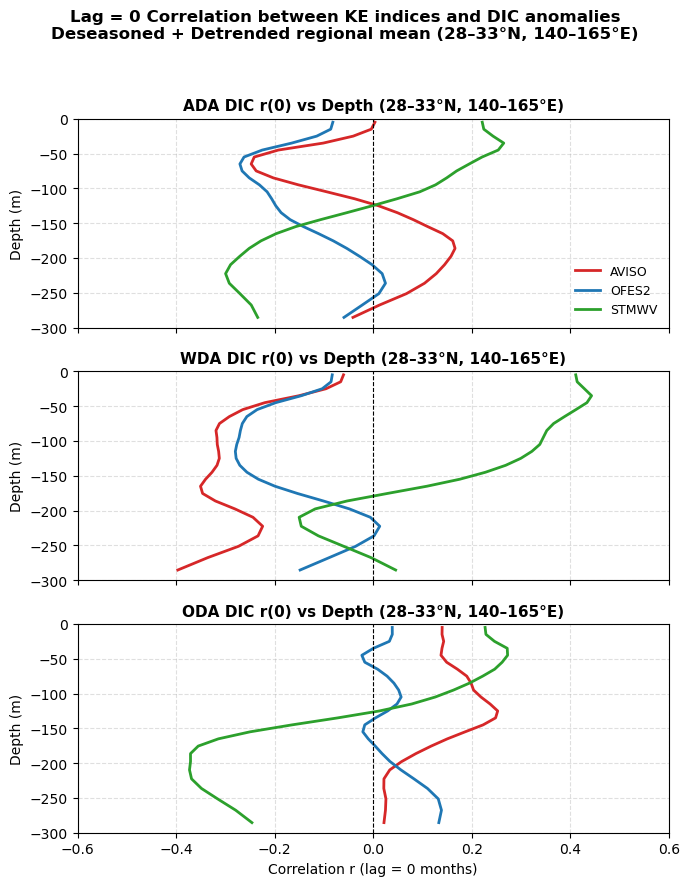

In [115]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# ==========================================================
# 1) Load KE indices
# ==========================================================
AVISO = xr.open_dataset("/proj/kimyy/tr_sysong/AVISO_KE_SSH_1993to2022.nc")["AVISO_KE_SSH"]
REANAL = xr.open_dataset("/proj/kimyy/tr_sysong/REANAL_KE_SSH_1958to2022.nc")["OFES2_KE_SSH"]
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")["PD7_STMWV"]
indices = {"AVISO": AVISO, "OFES2": REANAL, "STMWV": STMWV}

# ==========================================================
# 2) Extract regional DIC profile (28–33N, 140–165E)
# ==========================================================
def extract_dic_profile(ds_dic, lat_rng=(28,33), lon_rng=(140,165), zmax=-300):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = (ds_dic.sel(lat=slice(*lat_rng), lon=slice(*lon_rng))
                .sel(z_t=slice(0, zmax))
                .mean(dim=["lat","lon"]))
    return da

DICs = {
    "ADA": extract_dic_profile(cfg_var_DIC.ADA_ds_rgd),
    "WDA": extract_dic_profile(cfg_var_DIC.WDA_ds_rgd),
    "ODA": extract_dic_profile(cfg_var_DIC.ODA_ds_rgd),
}

# ==========================================================
# 3) Utilities: align, deseason, detrend, normalize
# ==========================================================
def to_datetime64(da):
    if not np.issubdtype(da.time.dtype, np.datetime64):
        da = da.copy()
        da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da

def deseason_detrend_normalize_common(da1, da2):
    da1, da2 = to_datetime64(da1), to_datetime64(da2)
    s1 = pd.Series(da1.values, index=pd.to_datetime(da1.time.values)).groupby(lambda t:(t.year,t.month)).mean()
    s2 = pd.Series(da2.values, index=pd.to_datetime(da2.time.values)).groupby(lambda t:(t.year,t.month)).mean()
    common = s1.index.intersection(s2.index)
    if len(common) < 12:
        return None
    s1, s2 = s1.loc[common], s2.loc[common]
    df = pd.DataFrame({"x": s1.values, "y": s2.values},
                      index=pd.to_datetime([f"{y}-{m:02d}-15" for y,m in common]))
    df = df.groupby(df.index.month).transform(lambda x: x - x.mean())
    x_idx = np.arange(len(df))
    for c in df.columns:
        s,i,*_ = linregress(x_idx, df[c]); df[c] -= (s*x_idx+i)
    df = (df - df.mean()) / df.std()
    return df["x"], df["y"]

def corr_at_zero(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 3: return np.nan
    return pearsonr(x[mask], y[mask])[0]

# ==========================================================
# 4) Compute r(0) vs depth for each DIC × index
# ==========================================================
r_depth = {dic:{idx:[] for idx in indices} for dic in DICs}
depths = DICs["ADA"].z_t.values

for dic_key, dic_da in DICs.items():
    for idx_key, idx_da in indices.items():
        print(f"Computing {dic_key} vs {idx_key}")
        vals = []
        for z in depths:
            y = dic_da.sel(z_t=z)
            result = deseason_detrend_normalize_common(idx_da, y)
            if result is None:
                vals.append(np.nan)
                continue
            x_idx, y_dic = result
            vals.append(corr_at_zero(x_idx, y_dic))
        r_depth[dic_key][idx_key] = np.array(vals)

# ==========================================================
# 5) Plot r(0) vs depth (3×1: ADA, WDA, ODA)
# ==========================================================
colors = {"AVISO":"C3","OFES2":"C0","STMWV":"C2"}
fig, axes = plt.subplots(3,1,figsize=(7,9),sharex=True,sharey=True)

for i,dic_key in enumerate(["ADA","WDA","ODA"]):
    ax = axes[i]
    for idx_key,color in colors.items():
        vals = r_depth[dic_key][idx_key]
        if not np.all(np.isnan(vals)):
            ax.plot(vals, depths, color=color, lw=2, label=idx_key)
    ax.axvline(0,color="k",ls="--",lw=0.8)
    ax.grid(ls="--",alpha=0.4)
    ax.set_ylim(0,-300)
    ax.invert_yaxis()
    ax.set_xlim(-0.6,0.6)
    ax.set_title(f"{dic_key} DIC r(0) vs Depth (28–33°N, 140–165°E)", fontsize=11, fontweight="bold")
    if i==2: ax.set_xlabel("Correlation r (lag = 0 months)")
    ax.set_ylabel("Depth (m)")

axes[0].legend(loc="lower right", frameon=False, fontsize=9)
plt.suptitle("Lag = 0 Correlation between KE indices and DIC anomalies\nDeseasoned + Detrended regional mean (28–33°N, 140–165°E)",
             fontsize=12, fontweight="bold")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


Computing r(0) vs depth: ADA vs AVISO
Computing r(0) vs depth: ADA vs OFES2
Computing r(0) vs depth: ADA vs STMWV
Computing r(0) vs depth: WDA vs AVISO
Computing r(0) vs depth: WDA vs OFES2
Computing r(0) vs depth: WDA vs STMWV
Computing r(0) vs depth: ODA vs AVISO
Computing r(0) vs depth: ODA vs OFES2
Computing r(0) vs depth: ODA vs STMWV


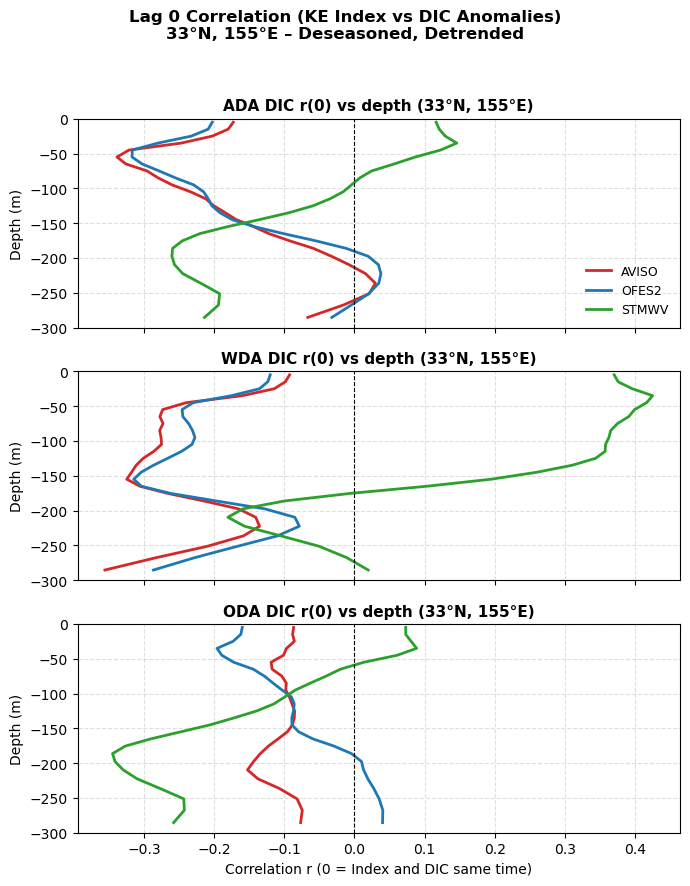

In [112]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# ----------------------------------------------------------
# 1) Helper: conversion + preprocessing
# ----------------------------------------------------------
def to_datetime64(da):
    if not np.issubdtype(da.time.dtype, np.datetime64):
        da = da.copy()
        da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da

def deseason_detrend_normalize_common(da1, da2):
    """Return deseasoned, detrended, normalized x, y on common period."""
    da1, da2 = to_datetime64(da1), to_datetime64(da2)
    da1["time"] = da1.indexes["time"].to_period("M").to_timestamp("M")
    da2["time"] = da2.indexes["time"].to_period("M").to_timestamp("M")
    common = np.intersect1d(da1.time.values, da2.time.values)
    if len(common) < 12:
        return None
    da1 = da1.sel(time=common)
    da2 = da2.sel(time=common)
    df = pd.DataFrame({"x": da1.values, "y": da2.values}, index=pd.to_datetime(common))
    df = df.groupby(df.index.month).transform(lambda x: x - x.mean())
    x_idx = np.arange(len(df))
    for c in df.columns:
        s, i, *_ = linregress(x_idx, df[c])
        df[c] -= (s * x_idx + i)
    df = (df - df.mean()) / df.std()
    return df["x"], df["y"]

def corr_at_zero(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    return pearsonr(x[mask], y[mask])[0] if mask.sum() > 3 else np.nan

# ----------------------------------------------------------
# 2) Load KE indices
# ----------------------------------------------------------
AVISO = xr.open_dataset("/proj/kimyy/tr_sysong/AVISO_KE_SSH_1993to2022.nc")["AVISO_KE_SSH"]
REANAL = xr.open_dataset("/proj/kimyy/tr_sysong/REANAL_KE_SSH_1958to2022.nc")["OFES2_KE_SSH"]
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")["PD7_STMWV"]
indices = {"AVISO": AVISO, "OFES2": REANAL, "STMWV": STMWV}

# ----------------------------------------------------------
# 3) Extract DIC profiles (lat = 31°, lon = 155°)
# ----------------------------------------------------------
def extract_dic_profile(ds_dic, lat_pt=33, lon_pt=155, zmax=-300):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = ds_dic.sel(lat=lat_pt, lon=lon_pt, method="nearest").sel(z_t=slice(0, zmax))
    return to_datetime64(da)

DICs = {
    "ADA": extract_dic_profile(cfg_var_DIC.ADA_ds_rgd),
    "WDA": extract_dic_profile(cfg_var_DIC.WDA_ds_rgd),
    "ODA": extract_dic_profile(cfg_var_DIC.ODA_ds_rgd),
}

# ----------------------------------------------------------
# 4) Compute r(0) vs depth
# ----------------------------------------------------------
r_depth = {dic: {idx: [] for idx in indices} for dic in DICs}
depths = DICs["ADA"].z_t.values

for dic_key, dic_da in DICs.items():
    for idx_key, idx_da in indices.items():
        print(f"Computing r(0) vs depth: {dic_key} vs {idx_key}")
        r_list = []
        for z in depths:
            y = dic_da.sel(z_t=z)
            res = deseason_detrend_normalize_common(idx_da, y)
            if res is None:
                r_list.append(np.nan)
                continue
            x_idx, y_dic = res
            r_list.append(corr_at_zero(np.array(x_idx), np.array(y_dic)))
        r_depth[dic_key][idx_key] = np.array(r_list)

# ----------------------------------------------------------
# 5) Plot 3×1 (ADA, WDA, ODA)
# ----------------------------------------------------------
colors = {"AVISO": "C3", "OFES2": "C0", "STMWV": "C2"}
fig, axes = plt.subplots(3, 1, figsize=(7, 9), sharex=True, sharey=True)

for i, dic_key in enumerate(["ADA", "WDA", "ODA"]):
    ax = axes[i]
    for idx_key, color in colors.items():
        ax.plot(r_depth[dic_key][idx_key], depths, color=color, lw=2, label=idx_key)
    ax.axvline(0, color="k", ls="--", lw=0.8)
    ax.set_ylim(0, -300)
    ax.invert_yaxis()
    ax.grid(ls="--", alpha=0.4)
    ax.set_title(f"{dic_key} DIC r(0) vs depth (33°N, 155°E)", fontsize=11, fontweight="bold")
    if i == 2:
        ax.set_xlabel("Correlation r (0 = Index and DIC same time)")
    ax.set_ylabel("Depth (m)")

axes[0].legend(loc="lower right", frameon=False, fontsize=9)
plt.suptitle("Lag 0 Correlation (KE Index vs DIC Anomalies)\n33°N, 155°E – Deseasoned, Detrended", fontsize=12, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [105]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress, pearsonr

# ==========================================================
# 1) Utility functions
# ==========================================================
def to_datetime64(da):
    if not np.issubdtype(da.time.dtype, np.datetime64):
        da = da.copy()
        da["time"] = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in da.time.values])
    return da

def deseason_detrend_normalize_common(da1, da2):
    da1, da2 = to_datetime64(da1), to_datetime64(da2)
    da1["time"] = da1.indexes["time"].to_period("M").to_timestamp("M")
    da2["time"] = da2.indexes["time"].to_period("M").to_timestamp("M")
    common_times = np.intersect1d(da1.time.values, da2.time.values)
    if len(common_times) < 12:
        return None
    da1 = da1.sel(time=common_times)
    da2 = da2.sel(time=common_times)
    df = pd.DataFrame({"x": da1.values, "y": da2.values}, index=pd.to_datetime(common_times))
    # remove seasonality
    df = df.groupby(df.index.month).transform(lambda x: x - x.mean())
    # remove linear trend
    x_idx = np.arange(len(df))
    for col in df.columns:
        slope, intercept, *_ = linregress(x_idx, df[col])
        df[col] -= (slope * x_idx + intercept)
    # normalize
    df = (df - df.mean()) / df.std()
    return df["x"], df["y"]

def corr_at_zero(x, y):
    """NaN-safe Pearson correlation."""
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() < 3:
        return np.nan
    return pearsonr(x[mask], y[mask])[0]

# ==========================================================
# 2) Load indices and DIC fields
# ==========================================================
AVISO = xr.open_dataset("/proj/kimyy/tr_sysong/AVISO_KE_SSH_1993to2022.nc")["AVISO_KE_SSH"]
REANAL = xr.open_dataset("/proj/kimyy/tr_sysong/REANAL_KE_SSH_1958to2022.nc")["OFES2_KE_SSH"]
STMWV = xr.open_dataset("/proj/kimyy/tr_sysong/STMWV_1958to2017.nc")["PD7_STMWV"]
indices = {"AVISO": AVISO, "OFES2": REANAL, "STMWV": STMWV}

def extract_dic_field(ds_dic, depth_pt=-200):
    ds_dic = ds_dic.assign_coords(z_t=-ds_dic.z_t / 100.0)
    da = ds_dic.sel(z_t=depth_pt, method="nearest").sel(lat=slice(31, 36), lon=slice(140, 165))
    return to_datetime64(da)

DICs = {
    "ADA": extract_dic_field(cfg_var_DIC.ADA_ds_rgd),
    "WDA": extract_dic_field(cfg_var_DIC.WDA_ds_rgd),
    "ODA": extract_dic_field(cfg_var_DIC.ODA_ds_rgd),
}

# ==========================================================
# 3) Compute correlation maps (lag = 0)
# ==========================================================
r_maps = {dic: {idx: None for idx in indices} for dic in DICs}

for dic_key, dic_da in DICs.items():
    for idx_key, idx_da in indices.items():
        print(f"Computing r(0) for {dic_key} vs {idx_key} ...")
        r_map = np.full((dic_da.lat.size, dic_da.lon.size), np.nan)
        for i, lat in enumerate(dic_da.lat.values):
            for j, lon in enumerate(dic_da.lon.values):
                y = dic_da.sel(lat=lat, lon=lon)
                result = deseason_detrend_normalize_common(idx_da, y)
                if result is None:
                    continue
                x_idx, y_dic = result
                r_map[i, j] = corr_at_zero(np.array(x_idx), np.array(y_dic))
        r_maps[dic_key][idx_key] = xr.DataArray(
            r_map, coords=[dic_da.lat, dic_da.lon],
            dims=["lat", "lon"], name=f"r0_{dic_key}_{idx_key}"
        )

# ==========================================================
# 4) Plot 3×3 panel
# ==========================================================
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(3, 3, figsize=(12, 9),
                         subplot_kw={"projection": proj})
vmin, vmax = -0.6, 0.6
dic_list = ["ADA", "WDA", "ODA"]
idx_list = ["AVISO", "OFES2", "STMWV"]

for i, dic_key in enumerate(dic_list):
    for j, idx_key in enumerate(idx_list):
        ax = axes[i, j]
        da_r = r_maps[dic_key][idx_key]
        pcm = da_r.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            cmap="RdBu_r", vmin=vmin, vmax=vmax,
            add_colorbar=False
        )
        ax.coastlines(resolution="110m", lw=0.5)
        ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=-1)
        ax.set_extent([140, 165, 31, 36], crs=proj)
        ax.set_xticks([140, 150, 160])
        ax.set_yticks([31, 33, 35])
        ax.gridlines(draw_labels=False, linestyle="--", alpha=0.3)
        if i == 0:
            ax.set_title(idx_key, fontsize=11, fontweight="bold")
        if j == 0:
            ax.text(-0.08, 0.5, dic_key, va="center", ha="right",
                    rotation=90, transform=ax.transAxes, fontsize=11, fontweight="bold")

# Colorbar (공통)
cax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label("r(0): Index vs DIC (Deseasoned, Detrended)", fontsize=10)

plt.suptitle("Lag-0 Correlation between KE Indices and DIC Anomalies\n(31–36°N, 140–165°E, ~200 m)", fontsize=13, fontweight="bold")
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


Computing r(0) for ADA vs AVISO ...
Computing r(0) for ADA vs OFES2 ...
Computing r(0) for ADA vs STMWV ...
Computing r(0) for WDA vs AVISO ...
Computing r(0) for WDA vs OFES2 ...
Computing r(0) for WDA vs STMWV ...
Computing r(0) for ODA vs AVISO ...
Computing r(0) for ODA vs OFES2 ...
Computing r(0) for ODA vs STMWV ...
